# Classification

## Preparation

### Install and Import

In [1]:
!pip install spacy -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.2 MB 26.4 MB/s 
     |████████████████████████████████| 660 kB 39.4 MB/s 
     |████████████████████████████████| 181 kB 71.1 MB/s 
     |████████████████████████████████| 42 kB 1.8 MB/s 
     |████████████████████████████████| 10.1 MB 60.4 MB/s 
     |████████████████████████████████| 457 kB 59.4 MB/s 
     |████████████████████████████████| 58 kB 6.9 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled sr

In [2]:
!pip install wordfreq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56.8 MB 1.3 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 749 kB 42.9 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20


In [3]:
!pip install mord

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for mord: filename=mord-0.6-py3-none-any.whl size=6006 sha256=2ecb63c5a6932dcc701bc6a675efb70f32512ed3a2d0fdfa7f7ea6eb08e1d4d5
  Stored in directory: /root/.cache/pip/wheels/80/1d/8a/bef1a01b6a3c91494905d161d5426c181819f9730a773141eb
Successfully built mord


In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from wordfreq import zipf_frequency
import seaborn as sns
import os
import pickle
import json
import joblib
import copy
from tqdm.notebook import tqdm

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import mord

In [3]:
model = "en_core_web_lg"
try:
    NLP = spacy.load(model)
except IOError:
    spacy.cli.download(model)
    NLP = spacy.load(model)

c:\users\family\appdata\local\programs\python\python37\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'en_core_web_lg' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


### Create Folders

In [4]:
def mkdirs(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [5]:
datasets = ("news", "days")
feature_sets = ("lexical", "grammatical", "all")

for dataset in datasets:
    mkdirs(os.path.join("results", dataset))

for feature_set in feature_sets:
    mkdirs(os.path.join("serialized", "models", feature_set))

mkdirs(os.path.join("serialized", "wordlists"))

for feature_set in feature_sets:
    mkdirs(os.path.join("illustrations", "news", feature_set))

mkdirs(os.path.join("illustrations", "days"))

### Small Functions for Serialization

In [6]:
def pickle_load(path):
    with open(path, "rb") as f:
        return pickle.load(f)

In [7]:
def pickle_dump(content, path):
    with open(path, "wb") as f:
        pickle.dump(content, f)

In [8]:
def json_load(path):
    with open(path, "r") as f:
        return json.load(f)

In [9]:
def json_dump(content, path):
    with open(path, "w") as f:
        f.write(json.dumps(content, default=lambda o: str(o)))

### Preprocess Word Lists

In [10]:
def preprocess_word_list(wordlist):
    input_path = os.path.join("wordlists", f"{wordlist}.txt")

    with open(input_path, encoding="utf-8") as f:
        words_from_list = f.read().split("\n")

    words_from_list = " ".join(
        [w for w in words_from_list if " " not in w and "-" not in w]
    )
    words_from_list = NLP(words_from_list)
    words_from_list = set(w.lemma_.lower() for w in words_from_list)

    output_path = os.path.join("serialized", "wordlists", f"{wordlist}.pkl")
    pickle_dump(words_from_list, output_path)

In [11]:
def create_word2level_dct():
    input_path = os.path.join("wordlists", "Vocabulary Framework – British English.csv")

    dct = {}
    df = pd.read_csv(input_path)
    sub_df = df[["Base Word", "Level"]]
    sub_df_min = sub_df.groupby("Base Word").min()

    for d, data in sub_df_min.reset_index().groupby("Level"):
        dct[d] = list(data["Base Word"])

    word2level = {}
    for level, words in dct.items():
        for i in range(len(words)):
            if " " not in words[i]:
                word2level[words[i].lower()] = level

    output_path = os.path.join("serialized", "wordlists", "word2level.json")
    json_dump(word2level, output_path)

In [12]:
for wordlist in ("abstract_nouns", "concrete_nouns"):
    preprocess_word_list(wordlist)

create_word2level_dct()

### Load Word Lists

In [13]:
folder = os.path.join("serialized", "wordlists")
ABSTRACT_NOUNS = pickle_load(os.path.join(folder, "abstract_nouns.pkl"))
CONCRETE_NOUNS = pickle_load(os.path.join(folder, "concrete_nouns.pkl"))
WORD2LEVEL = json_load(os.path.join(folder, "word2level.json"))

### Load Datasets

In [14]:
from parse_data import TextsinlevelsDB

In [15]:
textsinlevels = TextsinlevelsDB(db_name="data/textsinlevels")
df_news = textsinlevels.write_from_table_to_df("newsinlevels")
df_days = textsinlevels.write_from_table_to_df("daysinlevels")
del textsinlevels

In [16]:
LEVELS = ("A1", "A2", "B1", "B2", "C1", "C2")

## Feature Engineering

In [17]:
class Text:
    def __init__(self, tokens):
        self.tokens = tokens
        self.lemmas = self.lemmatize()
        if len(self.lemmas) < 5:
            raise ValueError("The text must have at least 5 words")
        self.dependencies = self.get_dependencies()

    def lemmatize(self):
        return [token.lemma_.lower() for token in self.tokens if token.is_alpha]

    def count_words(self):
        n_words = 0
        for token in self.tokens:
            if token.is_alpha:
                n_words += 1
        return n_words

    def count_sentences(self):
        n_sentences = 0
        for _ in self.tokens.sents:
            n_sentences += 1
        return n_sentences

    def count_type_token_ratio(self):
        return len(set(self.lemmas)) / len(self.lemmas)

    def count_words_from_wordlist(self, wordlist):
        words_from_wordlists = 0

        for lemma in self.lemmas:
            if lemma in wordlist:
                words_from_wordlists += 1

        return words_from_wordlists / len(self.lemmas)

    def count_words_from_level_lists(self):
        level_freqs = {level: 0 for level in LEVELS}

        for lemma in self.lemmas:
            level = WORD2LEVEL.get(lemma)
            if level:
                level_freqs[level] += 1

        for level in level_freqs:
            level_freqs[level] /= len(self.lemmas)

        return level_freqs

    def count_zipf_freqs(self):
        zipf_freqs = {}

        for lemma in self.lemmas:
            zipf_freq = math.floor(zipf_frequency(lemma, "en"))
            if zipf_freq in zipf_freqs:
                zipf_freqs[zipf_freq] += 1
            else:
                zipf_freqs[zipf_freq] = 1

        for zipf_freq in zipf_freqs:
            zipf_freqs[zipf_freq] /= len(self.lemmas)

        return zipf_freqs

    def get_pos(self):
        return " ".join([token.pos_ for token in self.tokens if token.is_alpha])

    def get_dependencies(self):
        return " ".join([token.dep_ for token in self.tokens if token.is_alpha])

    def count_mean_noun_chunk_len(self):
        noun_chunks = list(self.tokens.noun_chunks)
        len_noun_chunks = [len(noun_chunk) for noun_chunk in noun_chunks]
        if len_noun_chunks:
            return sum(len_noun_chunks) / len(noun_chunks)
        return 0

    def count_passiveness(self):
        active = 0
        passive = 0

        for dep in self.dependencies.split():
            if dep in {"aux", "csubj", "nsubj"}:
                active += 1
            elif dep in {"auxpass", "csubjpass", "nsubjpass"}:
                passive += 1

        passiveness = 0

        if passive + active > 0:
            passiveness = passive / (active + passive)

        return passiveness

    def count_mean_num_dependencies(self):
        num_dependencies = 0
        for token in self.tokens:
            if token.is_alpha:
                for child in token.children:
                    if child.is_alpha:
                        num_dependencies += 1
        if self.dependencies:
            return num_dependencies / len(self.dependencies.split())
        return 0

    def count_mean_arc_len(self):
        sum_arc_len = 0
        n_arcs = 0
        for token in self.tokens:
            if token.is_alpha:
                for child in token.children:
                    if child.is_alpha:
                        sum_arc_len += abs(token.i - child.i) - 1
                        n_arcs += 1
        if n_arcs:
            return sum_arc_len / n_arcs
        return 0

    def create_df(self):
        dct = {
            "words": [" ".join(self.lemmas)],
            "word_count": [self.count_words()],
            "type_token_ratio": [self.count_type_token_ratio()],
            "abstract_nouns": [self.count_words_from_wordlist(ABSTRACT_NOUNS)],
            "concrete_nouns": [self.count_words_from_wordlist(CONCRETE_NOUNS)],
            "pos": [self.get_pos()],
            "dep": [self.get_dependencies()],
            "mean_noun_chunk_len": [self.count_mean_noun_chunk_len()],
            "passiveness": [self.count_passiveness()],
            "mean_num_dependencies": [self.count_mean_num_dependencies()],
            "mean_arc_len": [self.count_mean_arc_len()],
        }

        zipf_freqs = self.count_zipf_freqs()

        for i in range(1, 7):
            dct[f"zipf_freqs_{i}"] = zipf_freqs.get(i, 0)

        levels = self.count_words_from_level_lists()
        for level in LEVELS:
            dct[level] = [levels[level]]

        df = pd.DataFrame(dct)
        return df

In [18]:
class TextDataset:
    def __init__(self, df, name, preprocess):
        self.df = df
        self.name = os.path.join("data", name)
        if preprocess:
            docs = spacy.tokens.DocBin(store_user_data=False)
            for doc in NLP.pipe(tqdm(self.df["article_text"])):
                docs.add(doc)
            docs.to_disk(self.name)
        else:
            docs = spacy.tokens.DocBin().from_disk(self.name)
        self.texts = [Text(doc) for doc in docs.get_docs(spacy.blank("en").vocab)]

    def count_words(self):
        return [text.count_words() for text in self.texts]

    def count_sentences(self):
        return [text.count_sentences() for text in self.texts]

    def lemmatize(self):
        return [text.lemmatize() for text in self.texts]

    def count_type_token_ratio(self):
        return [text.count_type_token_ratio() for text in self.texts]

    def count_words_from_wordlist(self, wordlist):
        return [text.count_words_from_wordlist(wordlist) for text in self.texts]

    def count_words_from_level_lists(self):
        return [text.count_words_from_level_lists() for text in self.texts]

    def count_zipf_freqs(self):
        return [text.count_zipf_freqs() for text in self.texts]

    def show_counts_info(self):
        print(self.name)
        d = {
            "Number of words": self.count_words(),
            "Number of sentences": self.count_sentences(),
        }
        df_stats = pd.DataFrame(d)
        print(df_stats.describe())

        f = plt.figure(figsize=(10, 4))
        plt.suptitle(self.name)
        gs = f.add_gridspec(1, 2)

        for i, col in enumerate(d):
            ax = f.add_subplot(gs[0, i])
            ax = sns.distplot(df_stats[col], bins=20)

        plt.show()
        illustration_path = os.path.join(
            "illustrations", self.name, f"{self.name}-words_sentences_counts.png"
        )
        f.savefig(illustration_path)

    def get_pos(self):
        return [text.get_pos() for text in self.texts]

    def get_dependencies(self):
        return [text.get_dependencies() for text in self.texts]

    def count_mean_noun_chunk_len(self):
        return [text.count_mean_noun_chunk_len() for text in self.texts]

    def count_passiveness(self):
        return [text.count_passiveness() for text in self.texts]

    def count_mean_num_dependencies(self):
        return [text.count_mean_num_dependencies() for text in self.texts]

    def count_mean_arc_len(self):
        return [text.count_mean_arc_len() for text in self.texts]

    def create_df(self):
        dct = {
            "words": [" ".join(self.texts[i].lemmas) for i in range(len(self.texts))],
            "word_count": self.count_words(),
            "type_token_ratio": self.count_type_token_ratio(),
            "abstract_nouns": self.count_words_from_wordlist(ABSTRACT_NOUNS),
            "concrete_nouns": self.count_words_from_wordlist(CONCRETE_NOUNS),
            "pos": self.get_pos(),
            "dep": self.get_dependencies(),
            "mean_noun_chunk_len": self.count_mean_noun_chunk_len(),
            "passiveness": self.count_passiveness(),
            "mean_num_dependencies": self.count_mean_num_dependencies(),
            "mean_arc_len": self.count_mean_arc_len(),
            "level": self.df["level"],
        }

        zipf_freqs = self.count_zipf_freqs()

        for i in range(1, 7):
            dct[f"zipf_freqs_{i}"] = [dct.get(i, 0) for dct in zipf_freqs]

        for level in LEVELS:
            dct[level] = [dct[level] for dct in self.count_words_from_level_lists()]

        df = pd.DataFrame(dct)
        return df

## Create Classification Pipeline

### Classes for Pipeline Elements

In [19]:
class PassthroughTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.X = X
        return X

    def get_feature_names(self):
        return self.X.columns.tolist()

In [20]:
class MyTfidfVectorizer(TfidfVectorizer):
    def fit_transform(self, raw_documents, y=None):
        X = TfidfVectorizer.fit_transform(self, raw_documents, y=None)
        try:
            return X / X.sum(axis=1)
        except:
            return X

    def transform(self, raw_documents):
        X = TfidfVectorizer.transform(self, raw_documents)
        n_words = X.sum(axis=1)
        try:
            return X / X.sum(axis=1)
        except:
            return X

### Functions for Visualization

In [21]:
def visualize_coefs(estimator, n_top_features, filename):

    coef = estimator[-1].coef_
    n_classes = coef.shape[0]
    feature_names = np.array(estimator.named_steps["vectorizer"].get_feature_names())
    print(len(feature_names))

    for n in range(n_classes):
        print("class", n)
        coefs = np.argsort(coef[n])

        if len(feature_names) > 2 * n_top_features:
            # индексы признаков, получивших cамые большие положительные коэффициенты
            pos_coefs = coefs[-n_top_features:]

            # индексы признаков, получивших самые низкие отрицательные коэффициенты
            neg_coefs = coefs[:n_top_features]

            interesting_coefs = np.hstack([neg_coefs, pos_coefs])

            plt.figure(figsize=(9, 3))
            colors = ["red" if c < 0 else "green" for c in coef[n][interesting_coefs]]
            plt.bar(
                np.arange(2 * n_top_features), coef[n][interesting_coefs], color=colors
            )
            plt.xticks(
                np.arange(2 * n_top_features),
                feature_names[interesting_coefs],
                rotation=90,
                ha="right",
            )
        else:
            colors = ["red" if c < 0 else "green" for c in coef[n][coefs]]
            plt.bar(np.arange(len(feature_names)), coef[n][coefs], color=colors)
            plt.xticks(
                np.arange(len(feature_names)),
                feature_names[coefs],
                rotation=90,
                ha="right",
            )

        plt.savefig(f"{filename}_class{n}.png", bbox_inches="tight")
        plt.show()

In [22]:
def visualize_feature_importances(estimator, n_top_features, filename):
    coef = estimator[-1].feature_importances_
    feature_names = np.array(estimator.named_steps["vectorizer"].get_feature_names())
    word_importances = pd.Series(coef, index=feature_names).sort_values(
        ascending=False
    )[:10]
    word_importances.plot(kind="bar")
    plt.tight_layout()
    plt.savefig(f"{filename}.png", bbox_inches="tight")
    plt.show()

### The Function for Evaluation

In [23]:
def quality(y_actual, y_pred):
    acc = accuracy_score(y_actual, y_pred)
    f1 = f1_score(y_actual, y_pred, average="macro")
    print(f"Accuracy: {acc:.4f}\nF1 macro: {f1:.4f}")

    cm = confusion_matrix(y_actual, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 16})
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

    return acc, f1

### Scaler, Vectorizer, Classifiers and Hyper-Parameters

In [24]:
scaler = MaxAbsScaler()
vectorizer = MyTfidfVectorizer()

In [25]:
TREE_BASED = {"tree", "adaboost", "random_forest", "extra_trees", "lgbm"}
WITH_COEFS = {"lr", "svm"}

In [26]:
random_state = 42

lr = LogisticRegression(solver="liblinear", random_state=random_state)
svm = LinearSVC(random_state=random_state)
tree = DecisionTreeClassifier(random_state=random_state)
adaboost = AdaBoostClassifier(random_state=random_state)
random_forest = RandomForestClassifier(random_state=random_state)
extra_trees = ExtraTreesClassifier(random_state=random_state)
lgbm = LGBMClassifier(random_state=random_state)
logistic_at = mord.LogisticAT()
logistic_it = mord.LogisticIT()
logistic_se = mord.LogisticSE()
ordinal_ridge = mord.OrdinalRidge(random_state=random_state)
lad = mord.LAD(random_state=random_state)

In [27]:
lr_params = dict(lr__C=[0.1, 0.5, 1], lr__penalty=["l1", "l2"])
svm_params = dict(svm__C=[0.01, 0.1, 1])
tree_params = dict(tree__max_depth=[None, 7, 10], tree__min_samples_leaf=[1, 10])
adaboost_params = dict(
    adaboost__base_estimator=[
        DecisionTreeClassifier(max_depth=1),
        DecisionTreeClassifier(max_depth=2),
    ]
)
random_forest_params = dict(
    random_forest__max_depth=[None, 10], random_forest__min_samples_leaf=[1, 5]
)
extra_trees_params = dict(
    extra_trees__max_depth=[None, 15], extra_trees__min_samples_leaf=[1, 15]
)
lgbm_params = dict(lgbm__min_split_gain=[0, 0.5], lgbm__colsample_bytree=[0.25, 0.5, 1])
logistic_at_params = dict(logistic_at__alpha=[0.5, 1, 5])
logistic_it_params = dict(logistic_it__alpha=[0.5, 1, 5])
logistic_se_params = dict(logistic_se__alpha=[0.5, 1, 5])
ordinal_ridge_params = dict(ordinal_ridge__alpha=[0.5, 1, 5])
lad_params = dict(lad__C=[0.01, 0.1, 1])

In [28]:
class Classifier:
    def __init__(self, name, clf, params):
        self.name = name
        self.clf = clf
        extended_params = copy.deepcopy(params)
        extended_params["vectorizer__word__min_df"] = [3, 5, 7]
        self.params = {
            "lexical": extended_params,
            "grammatical": params,
            "all": extended_params,
        }

In [34]:
clfs = (
    Classifier("lr", lr, lr_params),
    Classifier("svm", svm, svm_params),
    Classifier("tree", tree, tree_params),
    Classifier("adaboost", adaboost, adaboost_params),
    Classifier("random_forest", random_forest, random_forest_params),
    Classifier("extra_trees", extra_trees, extra_trees_params),
    Classifier("lgbm", lgbm, lgbm_params),
    Classifier("lad", lad, lad_params),
    Classifier("ordinal_ridge", ordinal_ridge, ordinal_ridge_params),
    Classifier("logistic_se", logistic_se, logistic_se_params),
    Classifier("logistic_at", logistic_at, logistic_at_params),
    Classifier("logistic_it", logistic_it, logistic_it_params),
)

In [29]:
clfs = (
#     Classifier("lr", lr, lr_params),
#     Classifier("svm", svm, svm_params),
#     Classifier("tree", tree, tree_params),
#     Classifier("adaboost", adaboost, adaboost_params),
#     Classifier("random_forest", random_forest, random_forest_params),
#     Classifier("extra_trees", extra_trees, extra_trees_params),
#     Classifier("lgbm", lgbm, lgbm_params),
#     Classifier("lad", lad, lad_params),
#     Classifier("ordinal_ridge", ordinal_ridge, ordinal_ridge_params),
#     Classifier("logistic_se", logistic_se, logistic_se_params),
#     Classifier("logistic_at", logistic_at, logistic_at_params),
    Classifier("logistic_it", logistic_it, logistic_it_params),
)

### Groups of Features and Column Transformers

In [30]:
lexical_features = [
    "zipf_freqs_1",
    "zipf_freqs_2",
    "zipf_freqs_3",
    "zipf_freqs_4",
    "zipf_freqs_5",
    "zipf_freqs_6",
    "A1",
    "A2",
    "B1",
    "B2",
    "C1",
    "C2",
    "type_token_ratio",
    "abstract_nouns",
    "concrete_nouns",
]

grammatical_features = [
    "mean_noun_chunk_len",
    "passiveness",
    "mean_num_dependencies",
    "mean_arc_len",
]

In [31]:
column_trans_lex = ColumnTransformer(
    [
        ("word", MyTfidfVectorizer(), "words"),
        ("lex", PassthroughTransformer(), lexical_features),
    ]
)

column_trans_gram = ColumnTransformer(
    [
        ("pos", MyTfidfVectorizer(), "pos"),
        ("dep", MyTfidfVectorizer(), "dep"),
        ("gram", PassthroughTransformer(), grammatical_features),
    ]
)

column_trans_all = ColumnTransformer(
    [
        ("word", vectorizer, "words"),
        ("pos", MyTfidfVectorizer(), "pos"),
        ("dep", MyTfidfVectorizer(), "dep"),
        ("feature", PassthroughTransformer(), lexical_features + grammatical_features),
    ]
)

In [32]:
column_trans_dct = {
    "lexical": column_trans_lex,
    "grammatical": column_trans_gram,
    "all": column_trans_all,
}

## Classification

In [33]:
class Dataset4Classification:
    def __init__(self, df, name, train=True):
        self.name = name

        df = TextDataset(df, name, preprocess=False).create_df()
        df["level"] = df["level"].map({1: 0, 2: 1, 3: 2})
        self.Y = df["level"]
        self.X = df.drop(columns=["level"])

        if train:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                self.X, self.Y, train_size=0.8, random_state=42, stratify=self.Y
            )
            keys = (
                "F1 macro (validation)",
                "Best params",
                "Accuracy (test)",
                "F1 macro (test)",
            )
        else:
            self.X_train, self.X_test, self.y_train, self.y_test = (
                None,
                self.X,
                None,
                self.Y,
            )
            keys = ("Accuracy (test)", "F1 macro (test)")

        self.results = {}
        for feature_set in feature_sets:
            self.results[feature_set] = {}
            for key in keys:
                self.results[feature_set][key] = {}

        self.baseline = self.count_baseline()

    def count_baseline(self):
        return self.y_test.value_counts(normalize=True).max()

    def classify(self, classif, column_trans_dct, scaler, feature_set):
        params = classif.params[feature_set]
        column_trans = column_trans_dct[feature_set]

        if classif.name in TREE_BASED:
            pipeline = Pipeline(
                steps=[("vectorizer", column_trans), (classif.name, classif.clf)]
            )
        else:
            pipeline = Pipeline(
                steps=[
                    ("vectorizer", column_trans),
                    ("scaler", scaler),
                    (classif.name, classif.clf),
                ]
            )

        grid_search = GridSearchCV(
            pipeline,
            param_grid=params,
            scoring={"F1": "f1_macro", "Accuracy": "accuracy"},
            refit="F1",
            return_train_score=True,
            cv=skf,
            verbose=10,
        )
        grid_search.fit(self.X_train, self.y_train)
        best_f1_val = round(grid_search.best_score_, 4)
        best_params = grid_search.best_params_
        print(feature_set)
        print(classif.name)
        print(f"Best f1 on validation: {best_f1_val}")
        print("Best parameters:", best_params, "\n")
        estimator = grid_search.best_estimator_
        y_pred_test = estimator.predict(self.X_test)
        acc, f1 = quality(self.y_test, y_pred_test)
        return grid_search, estimator, best_f1_val, best_params, acc, f1

    def classification(self, feature_set, clfs, column_trans_dct, scaler):
        for classif in clfs:
            (
                grid_search,
                estimator,
                best_f1_val,
                best_params,
                acc,
                f1,
            ) = %time self.classify(classif, column_trans_dct, scaler, feature_set)
            model_path = os.path.join(
                "serialized", "models", feature_set, f"{classif.name}.joblib"
            )
            joblib.dump(grid_search, model_path)

            for metric, value in {
                "F1 macro (validation)": best_f1_val,
                "Best params": best_params,
                "Accuracy (test)": round(acc, 4),
                "F1 macro (test)": round(f1, 4),
            }.items():
                self.results[feature_set][metric][classif.name] = value

            illustration_path = os.path.join(
                "illustrations", self.name, feature_set, classif.name
            )
            if classif.name in TREE_BASED:
                visualize_feature_importances(estimator, 10, illustration_path)
            elif classif.name in WITH_COEFS:
                visualize_coefs(estimator, 10, illustration_path)

    def prediction(self, feature_set, clfs):
        for classif in clfs:
            print(f"{feature_set}-{classif.name}")
            pipeline = joblib.load(
                os.path.join(
                    "serialized", "models", feature_set, f"{classif.name}.joblib"
                )
            )
            y_pred = pipeline.predict(self.X)
            acc, f1 = quality(y_actual=self.Y, y_pred=y_pred)
            self.results[feature_set]["Accuracy (test)"][classif.name] = round(acc, 4)
            self.results[feature_set]["F1 macro (test)"][classif.name] = round(f1, 4)

    def save_results(self, feature_set):
        result_path = os.path.join("results", self.name, f"{feature_set}-results.json")
        json_dump(self.results[feature_set], result_path)

    def plot_results(self, feature_set):
        result_path = os.path.join("results", self.name, f"{feature_set}-results.json")
        results = json_load(result_path)

        print(f"\n{feature_set}")
        print(f"Baseline: {self.baseline:.4f}")

        illustration_path = os.path.join(
            "illustrations", self.name, f"{feature_set}-results.png"
        )

        mini_df = pd.DataFrame(results)
        mini_df[["Accuracy (test)", "F1 macro (test)"]].plot.bar()
        plt.axhline(y=self.baseline, color="k")
        plt.ylim(0, 1)
        plt.savefig(illustration_path, bbox_inches="tight")
        plt.show()

        max_value = 0
        best_clf = ""
        for clf, value in results["F1 macro (test)"].items():
            if value > max_value:
                best_clf = clf
                max_value = value

        print("Best result:")
        print(best_clf)

        for metric in ("Accuracy (test)", "F1 macro (test)"):
            print(f"{metric}: {results[metric][best_clf]}")

        return best_clf

In [34]:
import warnings

warnings.filterwarnings("ignore")

In [35]:
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

## Classification for News

In [36]:
news = Dataset4Classification(df_news, "news")

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4; 1/18] START lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3......
[CV 1/4; 1/18] END lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3; Accuracy: (train=0.812, test=0.812) F1: (train=0.810, test=0.810) total time=   2.6s
[CV 2/4; 1/18] START lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3......
[CV 2/4; 1/18] END lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3; Accuracy: (train=0.818, test=0.800) F1: (train=0.816, test=0.798) total time=   2.6s
[CV 3/4; 1/18] START lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3......
[CV 3/4; 1/18] END lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3; Accuracy: (train=0.814, test=0.806) F1: (train=0.812, test=0.805) total time=   2.8s
[CV 4/4; 1/18] START lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3......
[CV 4/4; 1/18] END lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3; Accuracy: (train=0.818, test=0.809) F1: (train=0.816, test=0.806

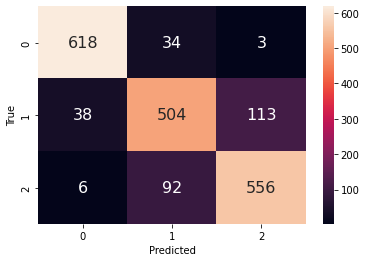

CPU times: user 4min 40s, sys: 22.3 s, total: 5min 2s
Wall time: 4min 39s
5892
class 0


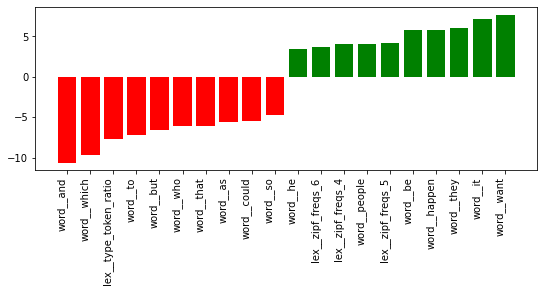

class 1


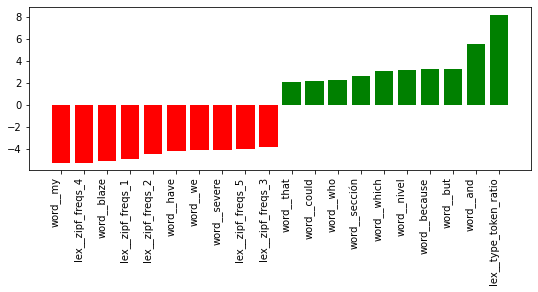

class 2


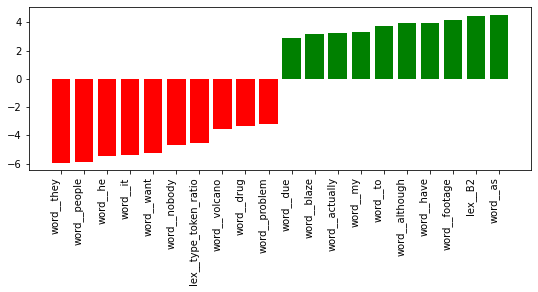

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4; 1/9] START svm__C=0.01, vectorizer__word__min_df=3.....................
[CV 1/4; 1/9] END svm__C=0.01, vectorizer__word__min_df=3; Accuracy: (train=0.907, test=0.837) F1: (train=0.906, test=0.832) total time=   1.9s
[CV 2/4; 1/9] START svm__C=0.01, vectorizer__word__min_df=3.....................
[CV 2/4; 1/9] END svm__C=0.01, vectorizer__word__min_df=3; Accuracy: (train=0.910, test=0.826) F1: (train=0.909, test=0.822) total time=   1.9s
[CV 3/4; 1/9] START svm__C=0.01, vectorizer__word__min_df=3.....................
[CV 3/4; 1/9] END svm__C=0.01, vectorizer__word__min_df=3; Accuracy: (train=0.906, test=0.850) F1: (train=0.905, test=0.848) total time=   1.9s
[CV 4/4; 1/9] START svm__C=0.01, vectorizer__word__min_df=3.....................
[CV 4/4; 1/9] END svm__C=0.01, vectorizer__word__min_df=3; Accuracy: (train=0.904, test=0.834) F1: (train=0.902, test=0.830) total time=   1.8s
[CV 1/4; 2/9] START svm__C=0.01, vectori

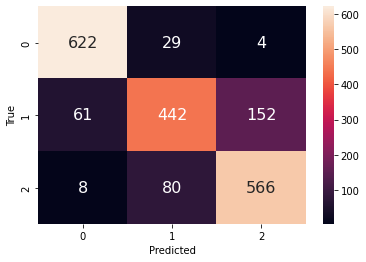

CPU times: user 1min 39s, sys: 10.8 s, total: 1min 50s
Wall time: 1min 38s
4803
class 0


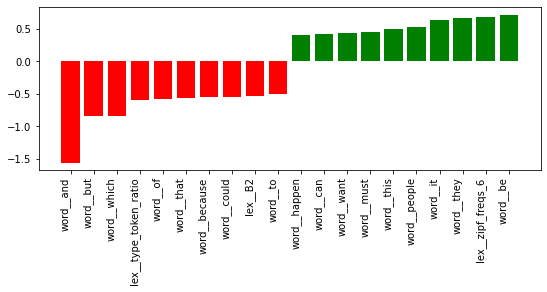

class 1


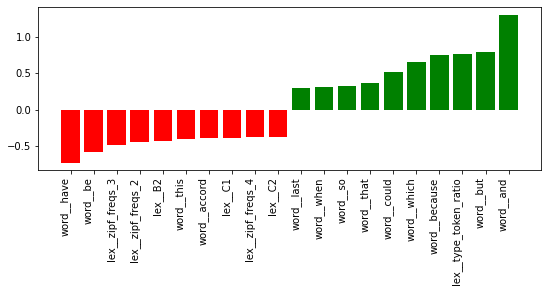

class 2


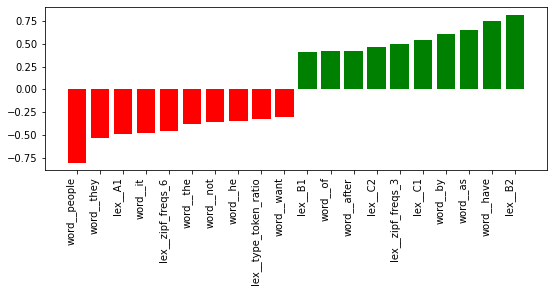

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4; 1/18] START tree__max_depth=None, tree__min_samples_leaf=1, vectorizer__word__min_df=3
[CV 1/4; 1/18] END tree__max_depth=None, tree__min_samples_leaf=1, vectorizer__word__min_df=3; Accuracy: (train=1.000, test=0.676) F1: (train=1.000, test=0.677) total time=   6.3s
[CV 2/4; 1/18] START tree__max_depth=None, tree__min_samples_leaf=1, vectorizer__word__min_df=3
[CV 2/4; 1/18] END tree__max_depth=None, tree__min_samples_leaf=1, vectorizer__word__min_df=3; Accuracy: (train=1.000, test=0.658) F1: (train=1.000, test=0.660) total time=   7.7s
[CV 3/4; 1/18] START tree__max_depth=None, tree__min_samples_leaf=1, vectorizer__word__min_df=3
[CV 3/4; 1/18] END tree__max_depth=None, tree__min_samples_leaf=1, vectorizer__word__min_df=3; Accuracy: (train=1.000, test=0.665) F1: (train=1.000, test=0.667) total time=   7.9s
[CV 4/4; 1/18] START tree__max_depth=None, tree__min_samples_leaf=1, vectorizer__word__min_df=3
[CV 4/4; 1/18] 

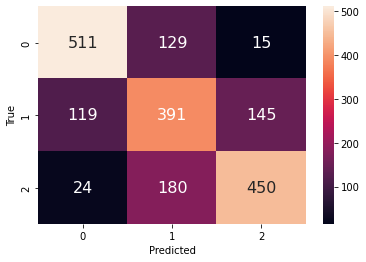

CPU times: user 6min 13s, sys: 4.52 s, total: 6min 18s
Wall time: 6min 16s


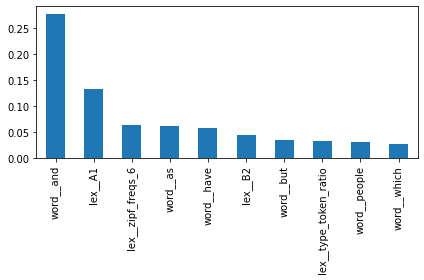

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV 1/4; 1/6] START adaboost__base_estimator=DecisionTreeClassifier(max_depth=1), vectorizer__word__min_df=3
[CV 1/4; 1/6] END adaboost__base_estimator=DecisionTreeClassifier(max_depth=1), vectorizer__word__min_df=3; Accuracy: (train=0.832, test=0.822) F1: (train=0.832, test=0.823) total time=  51.6s
[CV 2/4; 1/6] START adaboost__base_estimator=DecisionTreeClassifier(max_depth=1), vectorizer__word__min_df=3
[CV 2/4; 1/6] END adaboost__base_estimator=DecisionTreeClassifier(max_depth=1), vectorizer__word__min_df=3; Accuracy: (train=0.826, test=0.799) F1: (train=0.827, test=0.800) total time=  53.2s
[CV 3/4; 1/6] START adaboost__base_estimator=DecisionTreeClassifier(max_depth=1), vectorizer__word__min_df=3
[CV 3/4; 1/6] END adaboost__base_estimator=DecisionTreeClassifier(max_depth=1), vectorizer__word__min_df=3; Accuracy: (train=0.822, test=0.815) F1: (train=0.822, test=0.816) total time=  48.9s
[CV 4/4; 1/6] START adaboost__base

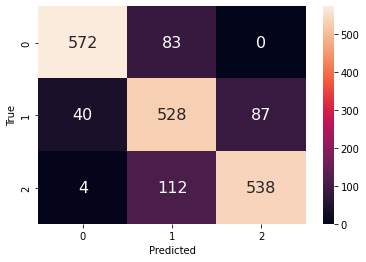

CPU times: user 24min 10s, sys: 9.87 s, total: 24min 20s
Wall time: 24min 10s


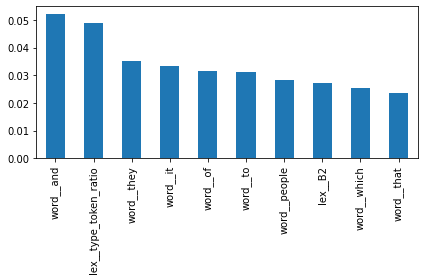

Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV 1/4; 1/12] START random_forest__max_depth=None, random_forest__min_samples_leaf=1, vectorizer__word__min_df=3
[CV 1/4; 1/12] END random_forest__max_depth=None, random_forest__min_samples_leaf=1, vectorizer__word__min_df=3; Accuracy: (train=1.000, test=0.813) F1: (train=1.000, test=0.812) total time=  12.1s
[CV 2/4; 1/12] START random_forest__max_depth=None, random_forest__min_samples_leaf=1, vectorizer__word__min_df=3
[CV 2/4; 1/12] END random_forest__max_depth=None, random_forest__min_samples_leaf=1, vectorizer__word__min_df=3; Accuracy: (train=1.000, test=0.801) F1: (train=1.000, test=0.801) total time=  11.7s
[CV 3/4; 1/12] START random_forest__max_depth=None, random_forest__min_samples_leaf=1, vectorizer__word__min_df=3
[CV 3/4; 1/12] END random_forest__max_depth=None, random_forest__min_samples_leaf=1, vectorizer__word__min_df=3; Accuracy: (train=1.000, test=0.817) F1: (train=1.000, test=0.815) total time=  12.4s
[CV

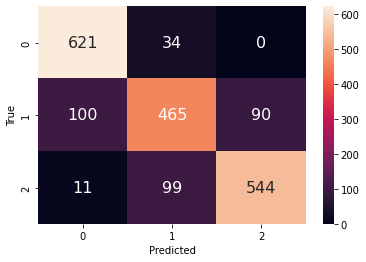

CPU times: user 6min 35s, sys: 2.72 s, total: 6min 38s
Wall time: 6min 36s


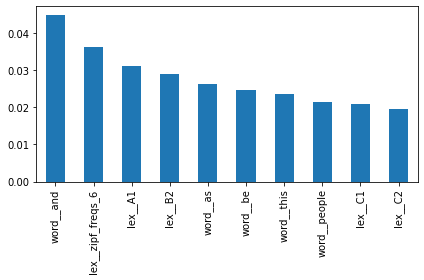

Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV 1/4; 1/12] START extra_trees__max_depth=None, extra_trees__min_samples_leaf=1, vectorizer__word__min_df=3
[CV 1/4; 1/12] END extra_trees__max_depth=None, extra_trees__min_samples_leaf=1, vectorizer__word__min_df=3; Accuracy: (train=1.000, test=0.793) F1: (train=1.000, test=0.789) total time=  26.9s
[CV 2/4; 1/12] START extra_trees__max_depth=None, extra_trees__min_samples_leaf=1, vectorizer__word__min_df=3
[CV 2/4; 1/12] END extra_trees__max_depth=None, extra_trees__min_samples_leaf=1, vectorizer__word__min_df=3; Accuracy: (train=1.000, test=0.774) F1: (train=1.000, test=0.770) total time=  27.3s
[CV 3/4; 1/12] START extra_trees__max_depth=None, extra_trees__min_samples_leaf=1, vectorizer__word__min_df=3
[CV 3/4; 1/12] END extra_trees__max_depth=None, extra_trees__min_samples_leaf=1, vectorizer__word__min_df=3; Accuracy: (train=1.000, test=0.800) F1: (train=1.000, test=0.796) total time=  26.5s
[CV 4/4; 1/12] START extra_

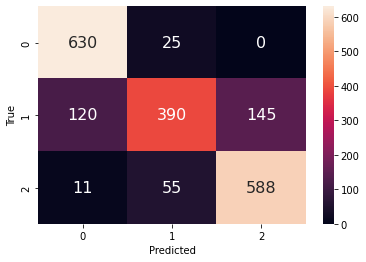

CPU times: user 12min 8s, sys: 3.15 s, total: 12min 12s
Wall time: 12min 8s


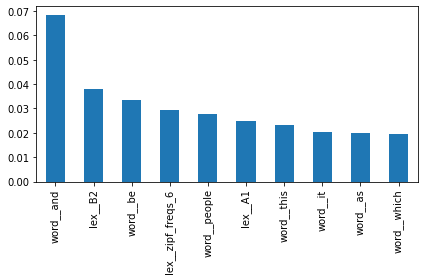

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4; 1/18] START lgbm__colsample_bytree=0.25, lgbm__min_split_gain=0, vectorizer__word__min_df=3
[CV 1/4; 1/18] END lgbm__colsample_bytree=0.25, lgbm__min_split_gain=0, vectorizer__word__min_df=3; Accuracy: (train=0.991, test=0.843) F1: (train=0.991, test=0.843) total time=  13.0s
[CV 2/4; 1/18] START lgbm__colsample_bytree=0.25, lgbm__min_split_gain=0, vectorizer__word__min_df=3
[CV 2/4; 1/18] END lgbm__colsample_bytree=0.25, lgbm__min_split_gain=0, vectorizer__word__min_df=3; Accuracy: (train=0.991, test=0.844) F1: (train=0.991, test=0.845) total time=  13.8s
[CV 3/4; 1/18] START lgbm__colsample_bytree=0.25, lgbm__min_split_gain=0, vectorizer__word__min_df=3
[CV 3/4; 1/18] END lgbm__colsample_bytree=0.25, lgbm__min_split_gain=0, vectorizer__word__min_df=3; Accuracy: (train=0.992, test=0.866) F1: (train=0.992, test=0.867) total time=  14.0s
[CV 4/4; 1/18] START lgbm__colsample_bytree=0.25, lgbm__min_split_gain=0, vectori

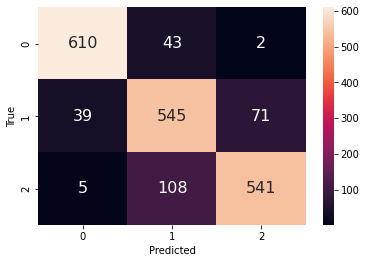

CPU times: user 21min 41s, sys: 9.72 s, total: 21min 51s
Wall time: 21min 45s


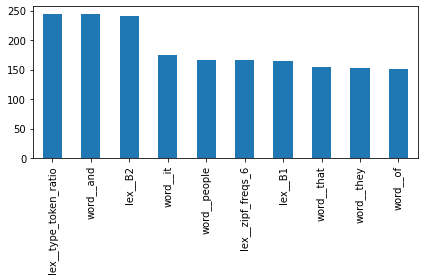

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4; 1/9] START lad__C=0.01, vectorizer__word__min_df=3.....................
[CV 1/4; 1/9] END lad__C=0.01, vectorizer__word__min_df=3; Accuracy: (train=0.860, test=0.808) F1: (train=0.863, test=0.813) total time=   1.8s
[CV 2/4; 1/9] START lad__C=0.01, vectorizer__word__min_df=3.....................
[CV 2/4; 1/9] END lad__C=0.01, vectorizer__word__min_df=3; Accuracy: (train=0.861, test=0.810) F1: (train=0.864, test=0.815) total time=   1.7s
[CV 3/4; 1/9] START lad__C=0.01, vectorizer__word__min_df=3.....................
[CV 3/4; 1/9] END lad__C=0.01, vectorizer__word__min_df=3; Accuracy: (train=0.855, test=0.819) F1: (train=0.858, test=0.823) total time=   1.7s
[CV 4/4; 1/9] START lad__C=0.01, vectorizer__word__min_df=3.....................
[CV 4/4; 1/9] END lad__C=0.01, vectorizer__word__min_df=3; Accuracy: (train=0.856, test=0.837) F1: (train=0.859, test=0.841) total time=   1.7s
[CV 1/4; 2/9] START lad__C=0.01, vectori

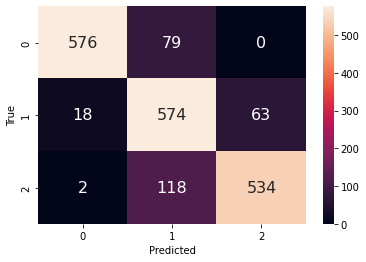

CPU times: user 1min 43s, sys: 11.1 s, total: 1min 54s
Wall time: 1min 45s
Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4; 1/9] START ordinal_ridge__alpha=0.5, vectorizer__word__min_df=3........
[CV 1/4; 1/9] END ordinal_ridge__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.997, test=0.770) F1: (train=0.997, test=0.775) total time=  12.7s
[CV 2/4; 1/9] START ordinal_ridge__alpha=0.5, vectorizer__word__min_df=3........
[CV 2/4; 1/9] END ordinal_ridge__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.997, test=0.775) F1: (train=0.997, test=0.780) total time=  12.6s
[CV 3/4; 1/9] START ordinal_ridge__alpha=0.5, vectorizer__word__min_df=3........
[CV 3/4; 1/9] END ordinal_ridge__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.996, test=0.795) F1: (train=0.996, test=0.799) total time=  12.8s
[CV 4/4; 1/9] START ordinal_ridge__alpha=0.5, vectorizer__word__min_df=3........
[CV 4/4; 1/9] END ordinal_ridge__alpha=0.5, vectorizer__word__min_df=3

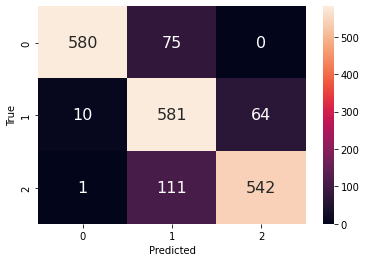

CPU times: user 9min 16s, sys: 35.5 s, total: 9min 51s
Wall time: 5min 57s
Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4; 1/9] START logistic_se__alpha=0.5, vectorizer__word__min_df=3..........
[CV 1/4; 1/9] END logistic_se__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.990, test=0.850) F1: (train=0.990, test=0.851) total time=  24.9s
[CV 2/4; 1/9] START logistic_se__alpha=0.5, vectorizer__word__min_df=3..........
[CV 2/4; 1/9] END logistic_se__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.990, test=0.853) F1: (train=0.990, test=0.854) total time=  22.1s
[CV 3/4; 1/9] START logistic_se__alpha=0.5, vectorizer__word__min_df=3..........
[CV 3/4; 1/9] END logistic_se__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.987, test=0.855) F1: (train=0.987, test=0.855) total time=  22.0s
[CV 4/4; 1/9] START logistic_se__alpha=0.5, vectorizer__word__min_df=3..........
[CV 4/4; 1/9] END logistic_se__alpha=0.5, vectorizer__word__min_df=3; Accura

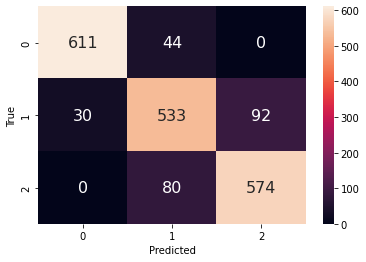

CPU times: user 14min 22s, sys: 51.3 s, total: 15min 13s
Wall time: 8min 29s
Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4; 1/9] START logistic_at__alpha=0.5, vectorizer__word__min_df=3..........
[CV 1/4; 1/9] END logistic_at__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.990, test=0.850) F1: (train=0.990, test=0.851) total time=  24.9s
[CV 2/4; 1/9] START logistic_at__alpha=0.5, vectorizer__word__min_df=3..........
[CV 2/4; 1/9] END logistic_at__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.990, test=0.854) F1: (train=0.990, test=0.854) total time=  23.1s
[CV 3/4; 1/9] START logistic_at__alpha=0.5, vectorizer__word__min_df=3..........
[CV 3/4; 1/9] END logistic_at__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.987, test=0.855) F1: (train=0.987, test=0.855) total time=  24.9s
[CV 4/4; 1/9] START logistic_at__alpha=0.5, vectorizer__word__min_df=3..........
[CV 4/4; 1/9] END logistic_at__alpha=0.5, vectorizer__word__min_df=3; Accu

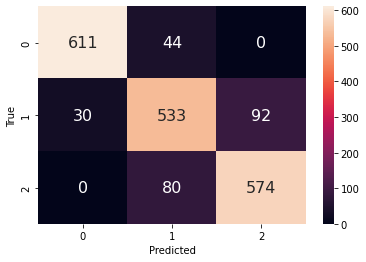

CPU times: user 15min 44s, sys: 52.2 s, total: 16min 36s
Wall time: 9min 12s
Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4; 1/9] START logistic_it__alpha=0.5, vectorizer__word__min_df=3..........
[CV 1/4; 1/9] END logistic_it__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.990, test=0.850) F1: (train=0.990, test=0.851) total time=  19.6s
[CV 2/4; 1/9] START logistic_it__alpha=0.5, vectorizer__word__min_df=3..........
[CV 2/4; 1/9] END logistic_it__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.990, test=0.854) F1: (train=0.990, test=0.854) total time=  18.1s
[CV 3/4; 1/9] START logistic_it__alpha=0.5, vectorizer__word__min_df=3..........
[CV 3/4; 1/9] END logistic_it__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.987, test=0.855) F1: (train=0.987, test=0.855) total time=  25.3s
[CV 4/4; 1/9] START logistic_it__alpha=0.5, vectorizer__word__min_df=3..........
[CV 4/4; 1/9] END logistic_it__alpha=0.5, vectorizer__word__min_df=3; Accu

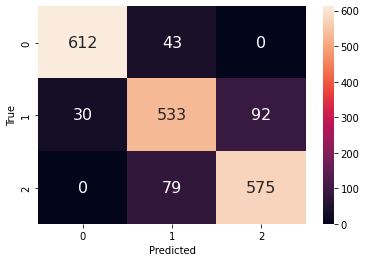

CPU times: user 15min 8s, sys: 51.4 s, total: 15min 59s
Wall time: 8min 53s
Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV 1/4; 1/6] START lr__C=0.1, lr__penalty=l1...................................
[CV 1/4; 1/6] END lr__C=0.1, lr__penalty=l1; Accuracy: (train=0.871, test=0.871) F1: (train=0.870, test=0.869) total time=   1.6s
[CV 2/4; 1/6] START lr__C=0.1, lr__penalty=l1...................................
[CV 2/4; 1/6] END lr__C=0.1, lr__penalty=l1; Accuracy: (train=0.870, test=0.873) F1: (train=0.868, test=0.870) total time=   1.6s
[CV 3/4; 1/6] START lr__C=0.1, lr__penalty=l1...................................
[CV 3/4; 1/6] END lr__C=0.1, lr__penalty=l1; Accuracy: (train=0.871, test=0.879) F1: (train=0.869, test=0.878) total time=   1.6s
[CV 4/4; 1/6] START lr__C=0.1, lr__penalty=l1...................................
[CV 4/4; 1/6] END lr__C=0.1, lr__penalty=l1; Accuracy: (train=0.875, test=0.860) F1: (train=0.873, test=0.858) total time=   1.8s
[CV 1/4; 2/6] START 

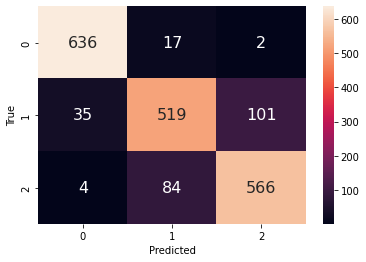

CPU times: user 1min 8s, sys: 5.36 s, total: 1min 13s
Wall time: 1min 7s
62
class 0


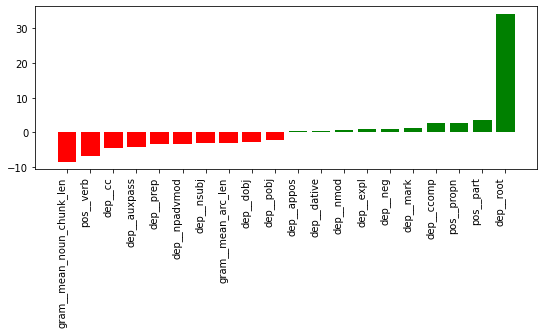

class 1


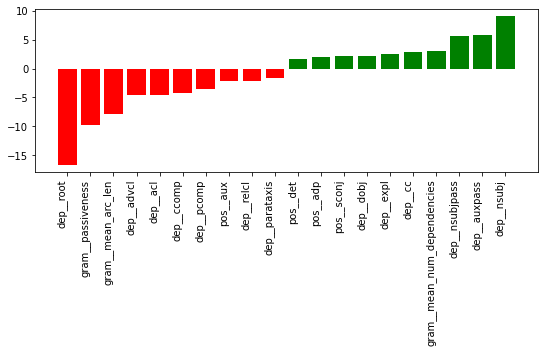

class 2


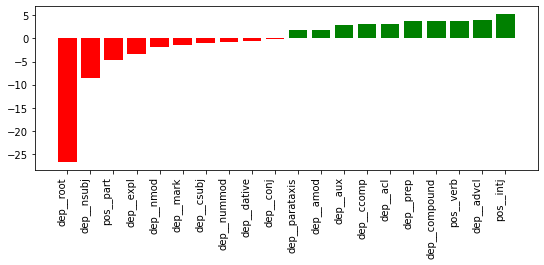

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4; 1/3] START svm__C=0.01.................................................
[CV 1/4; 1/3] END svm__C=0.01; Accuracy: (train=0.846, test=0.841) F1: (train=0.843, test=0.836) total time=   0.9s
[CV 2/4; 1/3] START svm__C=0.01.................................................
[CV 2/4; 1/3] END svm__C=0.01; Accuracy: (train=0.845, test=0.834) F1: (train=0.842, test=0.829) total time=   0.9s
[CV 3/4; 1/3] START svm__C=0.01.................................................
[CV 3/4; 1/3] END svm__C=0.01; Accuracy: (train=0.846, test=0.856) F1: (train=0.841, test=0.854) total time=   1.0s
[CV 4/4; 1/3] START svm__C=0.01.................................................
[CV 4/4; 1/3] END svm__C=0.01; Accuracy: (train=0.846, test=0.833) F1: (train=0.842, test=0.829) total time=   1.0s
[CV 1/4; 2/3] START svm__C=0.1..................................................
[CV 1/4; 2/3] END svm__C=0.1; Accuracy: (train=0.879, test=0.876) F1: (

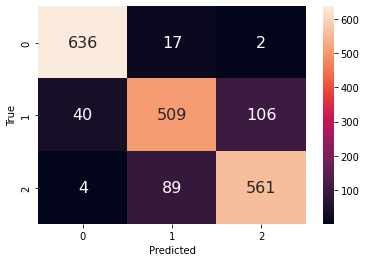

CPU times: user 22.7 s, sys: 2.77 s, total: 25.5 s
Wall time: 22.7 s
62
class 0


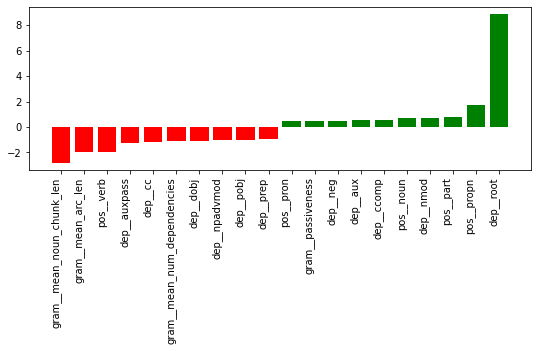

class 1


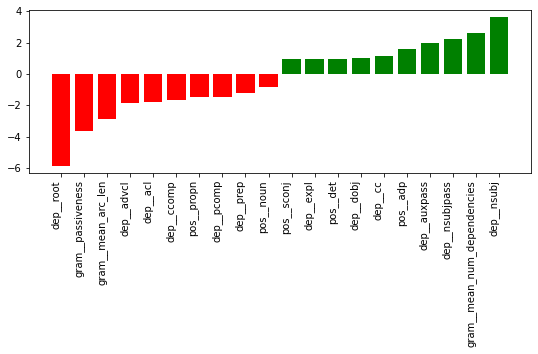

class 2


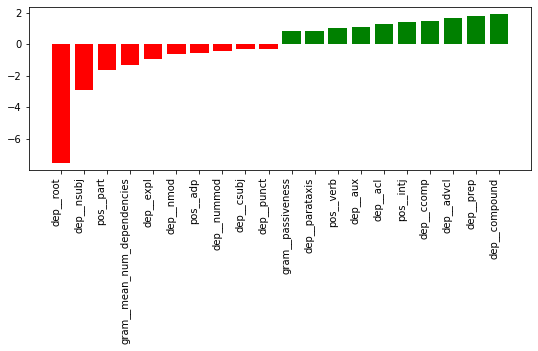

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV 1/4; 1/6] START tree__max_depth=None, tree__min_samples_leaf=1..............
[CV 1/4; 1/6] END tree__max_depth=None, tree__min_samples_leaf=1; Accuracy: (train=1.000, test=0.847) F1: (train=1.000, test=0.847) total time=   1.2s
[CV 2/4; 1/6] START tree__max_depth=None, tree__min_samples_leaf=1..............
[CV 2/4; 1/6] END tree__max_depth=None, tree__min_samples_leaf=1; Accuracy: (train=1.000, test=0.845) F1: (train=1.000, test=0.844) total time=   1.2s
[CV 3/4; 1/6] START tree__max_depth=None, tree__min_samples_leaf=1..............
[CV 3/4; 1/6] END tree__max_depth=None, tree__min_samples_leaf=1; Accuracy: (train=1.000, test=0.853) F1: (train=1.000, test=0.854) total time=   1.2s
[CV 4/4; 1/6] START tree__max_depth=None, tree__min_samples_leaf=1..............
[CV 4/4; 1/6] END tree__max_depth=None, tree__min_samples_leaf=1; Accuracy: (train=1.000, test=0.822) F1: (train=1.000, test=0.822) total time=   1.2s
[CV 1/4; 2/6

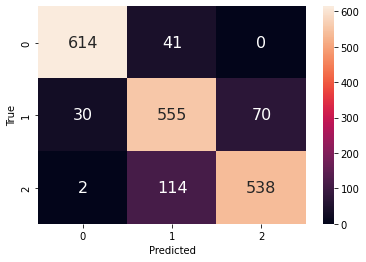

CPU times: user 44.8 s, sys: 317 ms, total: 45.1 s
Wall time: 45.2 s


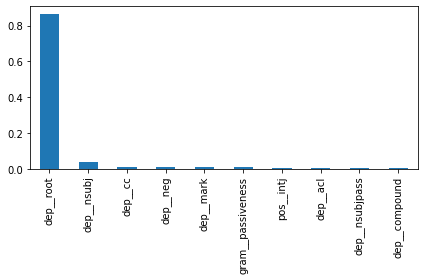

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV 1/4; 1/2] START adaboost__base_estimator=DecisionTreeClassifier(max_depth=1)
[CV 1/4; 1/2] END adaboost__base_estimator=DecisionTreeClassifier(max_depth=1); Accuracy: (train=0.850, test=0.847) F1: (train=0.849, test=0.846) total time=   2.8s
[CV 2/4; 1/2] START adaboost__base_estimator=DecisionTreeClassifier(max_depth=1)
[CV 2/4; 1/2] END adaboost__base_estimator=DecisionTreeClassifier(max_depth=1); Accuracy: (train=0.860, test=0.854) F1: (train=0.857, test=0.852) total time=   2.8s
[CV 3/4; 1/2] START adaboost__base_estimator=DecisionTreeClassifier(max_depth=1)
[CV 3/4; 1/2] END adaboost__base_estimator=DecisionTreeClassifier(max_depth=1); Accuracy: (train=0.842, test=0.828) F1: (train=0.842, test=0.828) total time=   2.8s
[CV 4/4; 1/2] START adaboost__base_estimator=DecisionTreeClassifier(max_depth=1)
[CV 4/4; 1/2] END adaboost__base_estimator=DecisionTreeClassifier(max_depth=1); Accuracy: (train=0.846, test=0.843) F1: (t

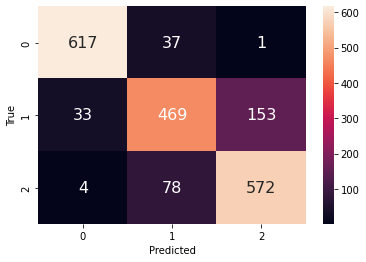

CPU times: user 38.1 s, sys: 293 ms, total: 38.4 s
Wall time: 38.3 s


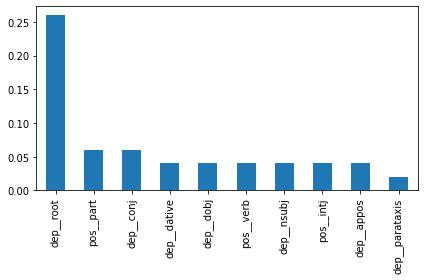

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4; 1/4] START random_forest__max_depth=None, random_forest__min_samples_leaf=1
[CV 1/4; 1/4] END random_forest__max_depth=None, random_forest__min_samples_leaf=1; Accuracy: (train=1.000, test=0.893) F1: (train=1.000, test=0.893) total time=   3.3s
[CV 2/4; 1/4] START random_forest__max_depth=None, random_forest__min_samples_leaf=1
[CV 2/4; 1/4] END random_forest__max_depth=None, random_forest__min_samples_leaf=1; Accuracy: (train=1.000, test=0.903) F1: (train=1.000, test=0.903) total time=   3.4s
[CV 3/4; 1/4] START random_forest__max_depth=None, random_forest__min_samples_leaf=1
[CV 3/4; 1/4] END random_forest__max_depth=None, random_forest__min_samples_leaf=1; Accuracy: (train=1.000, test=0.895) F1: (train=1.000, test=0.896) total time=   3.3s
[CV 4/4; 1/4] START random_forest__max_depth=None, random_forest__min_samples_leaf=1
[CV 4/4; 1/4] END random_forest__max_depth=None, random_forest__min_samples_leaf=1; Accuracy:

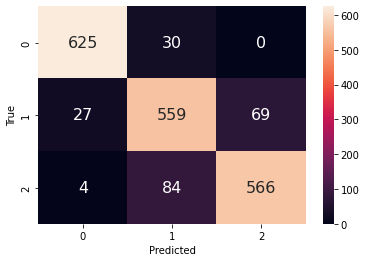

CPU times: user 1min 4s, sys: 338 ms, total: 1min 5s
Wall time: 1min 5s


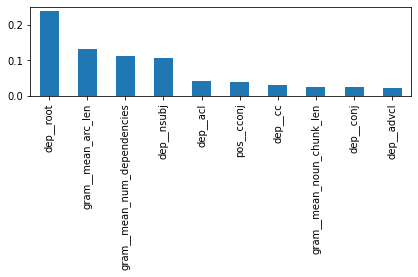

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4; 1/4] START extra_trees__max_depth=None, extra_trees__min_samples_leaf=1
[CV 1/4; 1/4] END extra_trees__max_depth=None, extra_trees__min_samples_leaf=1; Accuracy: (train=1.000, test=0.900) F1: (train=1.000, test=0.900) total time=   1.8s
[CV 2/4; 1/4] START extra_trees__max_depth=None, extra_trees__min_samples_leaf=1
[CV 2/4; 1/4] END extra_trees__max_depth=None, extra_trees__min_samples_leaf=1; Accuracy: (train=1.000, test=0.903) F1: (train=1.000, test=0.903) total time=   1.8s
[CV 3/4; 1/4] START extra_trees__max_depth=None, extra_trees__min_samples_leaf=1
[CV 3/4; 1/4] END extra_trees__max_depth=None, extra_trees__min_samples_leaf=1; Accuracy: (train=1.000, test=0.896) F1: (train=1.000, test=0.896) total time=   1.8s
[CV 4/4; 1/4] START extra_trees__max_depth=None, extra_trees__min_samples_leaf=1
[CV 4/4; 1/4] END extra_trees__max_depth=None, extra_trees__min_samples_leaf=1; Accuracy: (train=1.000, test=0.888) F1: (

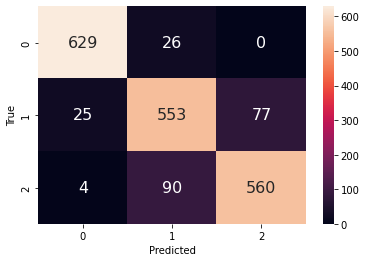

CPU times: user 39.5 s, sys: 325 ms, total: 39.8 s
Wall time: 39.7 s


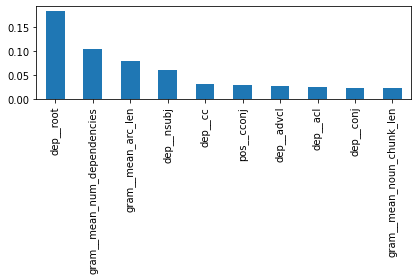

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV 1/4; 1/6] START lgbm__colsample_bytree=0.25, lgbm__min_split_gain=0.........
[CV 1/4; 1/6] END lgbm__colsample_bytree=0.25, lgbm__min_split_gain=0; Accuracy: (train=0.996, test=0.902) F1: (train=0.996, test=0.902) total time=   2.1s
[CV 2/4; 1/6] START lgbm__colsample_bytree=0.25, lgbm__min_split_gain=0.........
[CV 2/4; 1/6] END lgbm__colsample_bytree=0.25, lgbm__min_split_gain=0; Accuracy: (train=0.996, test=0.909) F1: (train=0.996, test=0.909) total time=   2.2s
[CV 3/4; 1/6] START lgbm__colsample_bytree=0.25, lgbm__min_split_gain=0.........
[CV 3/4; 1/6] END lgbm__colsample_bytree=0.25, lgbm__min_split_gain=0; Accuracy: (train=0.995, test=0.899) F1: (train=0.995, test=0.899) total time=   2.1s
[CV 4/4; 1/6] START lgbm__colsample_bytree=0.25, lgbm__min_split_gain=0.........
[CV 4/4; 1/6] END lgbm__colsample_bytree=0.25, lgbm__min_split_gain=0; Accuracy: (train=0.996, test=0.898) F1: (train=0.996, test=0.898) total time=

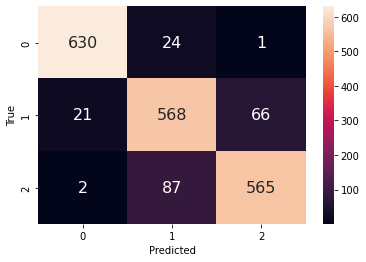

CPU times: user 1min 28s, sys: 948 ms, total: 1min 29s
Wall time: 1min 28s


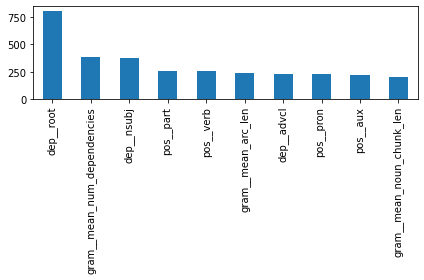

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4; 1/3] START lad__C=0.01.................................................
[CV 1/4; 1/3] END lad__C=0.01; Accuracy: (train=0.861, test=0.856) F1: (train=0.864, test=0.859) total time=   0.9s
[CV 2/4; 1/3] START lad__C=0.01.................................................
[CV 2/4; 1/3] END lad__C=0.01; Accuracy: (train=0.860, test=0.851) F1: (train=0.863, test=0.855) total time=   0.9s
[CV 3/4; 1/3] START lad__C=0.01.................................................
[CV 3/4; 1/3] END lad__C=0.01; Accuracy: (train=0.860, test=0.864) F1: (train=0.863, test=0.867) total time=   0.9s
[CV 4/4; 1/3] START lad__C=0.01.................................................
[CV 4/4; 1/3] END lad__C=0.01; Accuracy: (train=0.858, test=0.863) F1: (train=0.861, test=0.866) total time=   0.9s
[CV 1/4; 2/3] START lad__C=0.1..................................................
[CV 1/4; 2/3] END lad__C=0.1; Accuracy: (train=0.872, test=0.863) F1: (

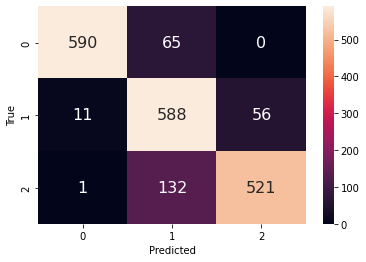

CPU times: user 21.5 s, sys: 2.79 s, total: 24.3 s
Wall time: 21.4 s
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4; 1/3] START ordinal_ridge__alpha=0.5....................................
[CV 1/4; 1/3] END ordinal_ridge__alpha=0.5; Accuracy: (train=0.874, test=0.867) F1: (train=0.877, test=0.869) total time=   0.9s
[CV 2/4; 1/3] START ordinal_ridge__alpha=0.5....................................
[CV 2/4; 1/3] END ordinal_ridge__alpha=0.5; Accuracy: (train=0.872, test=0.870) F1: (train=0.875, test=0.872) total time=   1.0s
[CV 3/4; 1/3] START ordinal_ridge__alpha=0.5....................................
[CV 3/4; 1/3] END ordinal_ridge__alpha=0.5; Accuracy: (train=0.876, test=0.878) F1: (train=0.878, test=0.880) total time=   1.0s
[CV 4/4; 1/3] START ordinal_ridge__alpha=0.5....................................
[CV 4/4; 1/3] END ordinal_ridge__alpha=0.5; Accuracy: (train=0.873, test=0.869) F1: (train=0.875, test=0.871) total time=   1.0s
[CV 1/4; 2/3] START ordinal_rid

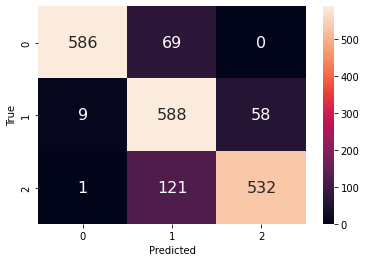

CPU times: user 21.9 s, sys: 4.07 s, total: 26 s
Wall time: 21.6 s
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4; 1/3] START logistic_se__alpha=0.5......................................
[CV 1/4; 1/3] END logistic_se__alpha=0.5; Accuracy: (train=0.898, test=0.891) F1: (train=0.898, test=0.891) total time=   1.7s
[CV 2/4; 1/3] START logistic_se__alpha=0.5......................................
[CV 2/4; 1/3] END logistic_se__alpha=0.5; Accuracy: (train=0.895, test=0.900) F1: (train=0.895, test=0.900) total time=   1.8s
[CV 3/4; 1/3] START logistic_se__alpha=0.5......................................
[CV 3/4; 1/3] END logistic_se__alpha=0.5; Accuracy: (train=0.898, test=0.895) F1: (train=0.898, test=0.895) total time=   1.8s
[CV 4/4; 1/3] START logistic_se__alpha=0.5......................................
[CV 4/4; 1/3] END logistic_se__alpha=0.5; Accuracy: (train=0.899, test=0.896) F1: (train=0.899, test=0.896) total time=   1.7s
[CV 1/4; 2/3] START logistic_se__alpha=1.

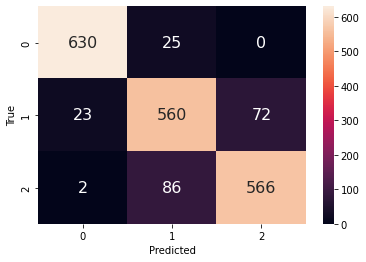

CPU times: user 30.9 s, sys: 9.69 s, total: 40.6 s
Wall time: 29.1 s
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4; 1/3] START logistic_at__alpha=0.5......................................
[CV 1/4; 1/3] END logistic_at__alpha=0.5; Accuracy: (train=0.898, test=0.890) F1: (train=0.899, test=0.890) total time=   1.8s
[CV 2/4; 1/3] START logistic_at__alpha=0.5......................................
[CV 2/4; 1/3] END logistic_at__alpha=0.5; Accuracy: (train=0.894, test=0.899) F1: (train=0.894, test=0.899) total time=   1.8s
[CV 3/4; 1/3] START logistic_at__alpha=0.5......................................
[CV 3/4; 1/3] END logistic_at__alpha=0.5; Accuracy: (train=0.898, test=0.895) F1: (train=0.898, test=0.895) total time=   1.7s
[CV 4/4; 1/3] START logistic_at__alpha=0.5......................................
[CV 4/4; 1/3] END logistic_at__alpha=0.5; Accuracy: (train=0.898, test=0.894) F1: (train=0.898, test=0.894) total time=   1.7s
[CV 1/4; 2/3] START logistic_at__alpha=

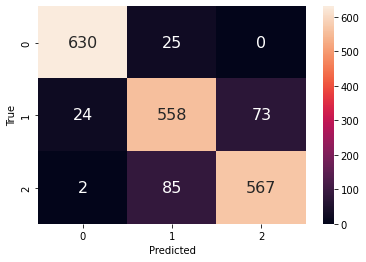

CPU times: user 31.6 s, sys: 10.1 s, total: 41.7 s
Wall time: 29.7 s
Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4; 1/3] START logistic_it__alpha=0.5......................................
[CV 1/4; 1/3] END logistic_it__alpha=0.5; Accuracy: (train=0.898, test=0.890) F1: (train=0.898, test=0.890) total time=   1.8s
[CV 2/4; 1/3] START logistic_it__alpha=0.5......................................
[CV 2/4; 1/3] END logistic_it__alpha=0.5; Accuracy: (train=0.894, test=0.899) F1: (train=0.894, test=0.899) total time=   1.7s
[CV 3/4; 1/3] START logistic_it__alpha=0.5......................................
[CV 3/4; 1/3] END logistic_it__alpha=0.5; Accuracy: (train=0.898, test=0.895) F1: (train=0.898, test=0.896) total time=   1.6s
[CV 4/4; 1/3] START logistic_it__alpha=0.5......................................
[CV 4/4; 1/3] END logistic_it__alpha=0.5; Accuracy: (train=0.898, test=0.894) F1: (train=0.899, test=0.894) total time=   1.6s
[CV 1/4; 2/3] START logistic_it__alpha=

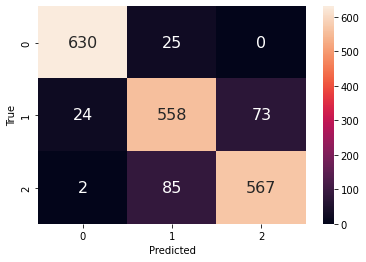

CPU times: user 30.1 s, sys: 9.01 s, total: 39.1 s
Wall time: 28.3 s
Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4; 1/18] START lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3......
[CV 1/4; 1/18] END lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3; Accuracy: (train=0.894, test=0.901) F1: (train=0.893, test=0.899) total time=   3.2s
[CV 2/4; 1/18] START lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3......
[CV 2/4; 1/18] END lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3; Accuracy: (train=0.898, test=0.896) F1: (train=0.897, test=0.895) total time=   3.3s
[CV 3/4; 1/18] START lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3......
[CV 3/4; 1/18] END lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3; Accuracy: (train=0.899, test=0.899) F1: (train=0.899, test=0.898) total time=   2.9s
[CV 4/4; 1/18] START lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3......
[CV 4/4; 1/18] END lr__C=0.1, lr__penalty=l1, vectorizer__word__min_d

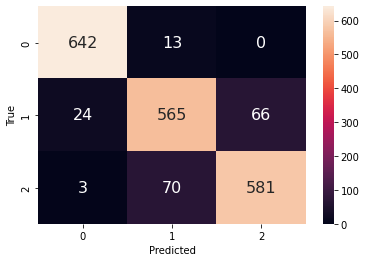

CPU times: user 6min 12s, sys: 23 s, total: 6min 35s
Wall time: 6min 12s
8630
class 0


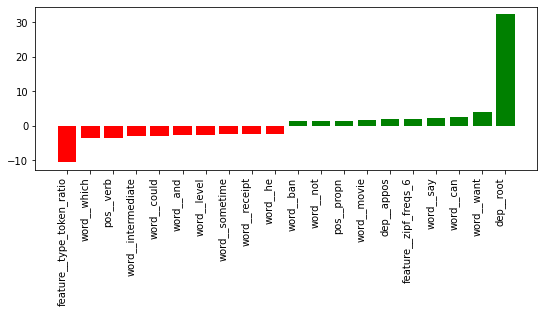

class 1


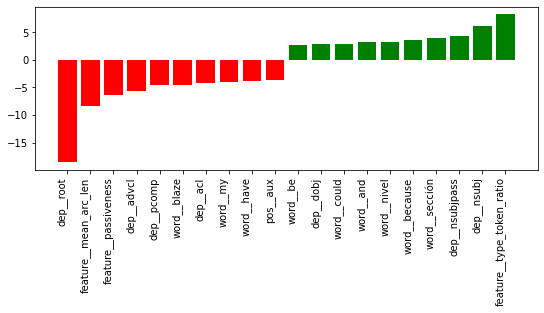

class 2


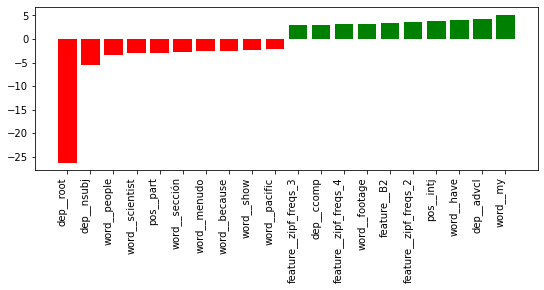

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4; 1/9] START svm__C=0.01, vectorizer__word__min_df=3.....................
[CV 1/4; 1/9] END svm__C=0.01, vectorizer__word__min_df=3; Accuracy: (train=0.933, test=0.884) F1: (train=0.933, test=0.882) total time=   2.8s
[CV 2/4; 1/9] START svm__C=0.01, vectorizer__word__min_df=3.....................
[CV 2/4; 1/9] END svm__C=0.01, vectorizer__word__min_df=3; Accuracy: (train=0.932, test=0.875) F1: (train=0.932, test=0.873) total time=   2.8s
[CV 3/4; 1/9] START svm__C=0.01, vectorizer__word__min_df=3.....................
[CV 3/4; 1/9] END svm__C=0.01, vectorizer__word__min_df=3; Accuracy: (train=0.931, test=0.891) F1: (train=0.931, test=0.891) total time=   2.8s
[CV 4/4; 1/9] START svm__C=0.01, vectorizer__word__min_df=3.....................
[CV 4/4; 1/9] END svm__C=0.01, vectorizer__word__min_df=3; Accuracy: (train=0.931, test=0.877) F1: (train=0.931, test=0.875) total time=   2.8s
[CV 1/4; 2/9] START svm__C=0.01, vectori

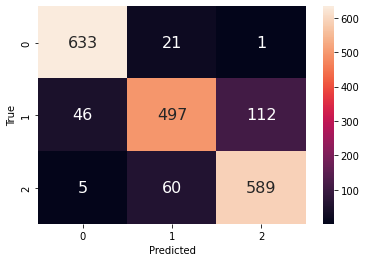

CPU times: user 2min 38s, sys: 11.7 s, total: 2min 49s
Wall time: 2min 37s
5954
class 0


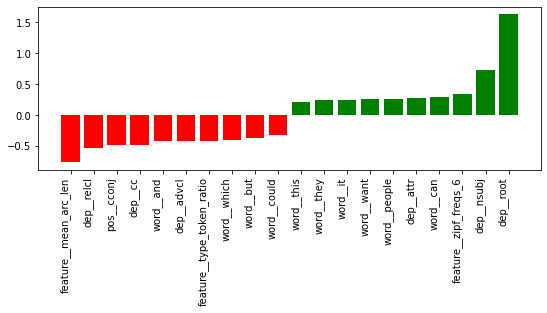

class 1


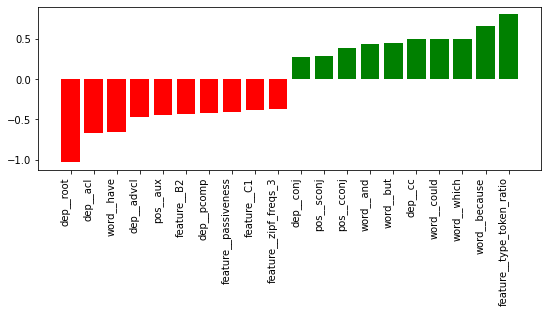

class 2


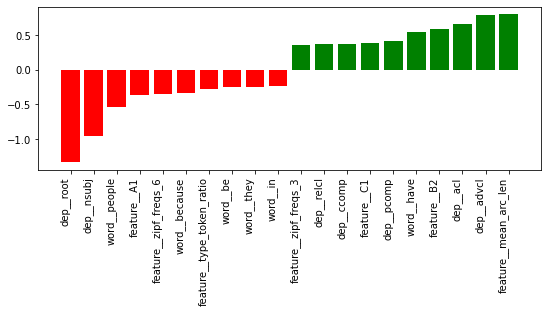

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4; 1/18] START tree__max_depth=None, tree__min_samples_leaf=1, vectorizer__word__min_df=3
[CV 1/4; 1/18] END tree__max_depth=None, tree__min_samples_leaf=1, vectorizer__word__min_df=3; Accuracy: (train=1.000, test=0.861) F1: (train=1.000, test=0.861) total time=  13.0s
[CV 2/4; 1/18] START tree__max_depth=None, tree__min_samples_leaf=1, vectorizer__word__min_df=3
[CV 2/4; 1/18] END tree__max_depth=None, tree__min_samples_leaf=1, vectorizer__word__min_df=3; Accuracy: (train=1.000, test=0.863) F1: (train=1.000, test=0.863) total time=  11.7s
[CV 3/4; 1/18] START tree__max_depth=None, tree__min_samples_leaf=1, vectorizer__word__min_df=3
[CV 3/4; 1/18] END tree__max_depth=None, tree__min_samples_leaf=1, vectorizer__word__min_df=3; Accuracy: (train=1.000, test=0.860) F1: (train=1.000, test=0.860) total time=  11.3s
[CV 4/4; 1/18] START tree__max_depth=None, tree__min_samples_leaf=1, vectorizer__word__min_df=3
[CV 4/4; 1/18] 

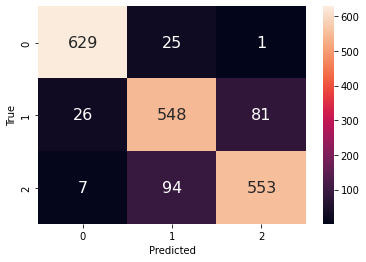

CPU times: user 9min 28s, sys: 5.42 s, total: 9min 33s
Wall time: 9min 31s


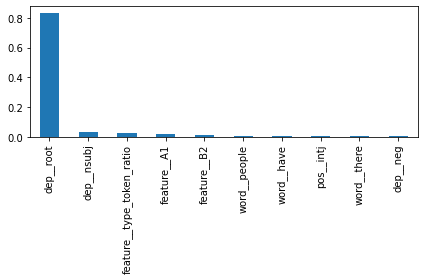

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV 1/4; 1/6] START adaboost__base_estimator=DecisionTreeClassifier(max_depth=1), vectorizer__word__min_df=3
[CV 1/4; 1/6] END adaboost__base_estimator=DecisionTreeClassifier(max_depth=1), vectorizer__word__min_df=3; Accuracy: (train=0.892, test=0.878) F1: (train=0.892, test=0.878) total time=  57.7s
[CV 2/4; 1/6] START adaboost__base_estimator=DecisionTreeClassifier(max_depth=1), vectorizer__word__min_df=3
[CV 2/4; 1/6] END adaboost__base_estimator=DecisionTreeClassifier(max_depth=1), vectorizer__word__min_df=3; Accuracy: (train=0.883, test=0.882) F1: (train=0.884, test=0.882) total time=  57.8s
[CV 3/4; 1/6] START adaboost__base_estimator=DecisionTreeClassifier(max_depth=1), vectorizer__word__min_df=3
[CV 3/4; 1/6] END adaboost__base_estimator=DecisionTreeClassifier(max_depth=1), vectorizer__word__min_df=3; Accuracy: (train=0.874, test=0.867) F1: (train=0.874, test=0.867) total time=  56.1s
[CV 4/4; 1/6] START adaboost__base

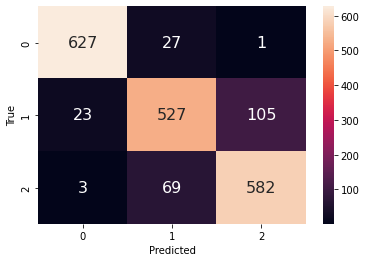

CPU times: user 27min 19s, sys: 11.4 s, total: 27min 31s
Wall time: 27min 19s


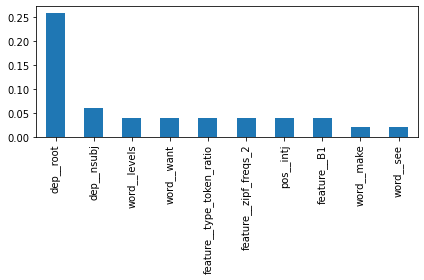

Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV 1/4; 1/12] START random_forest__max_depth=None, random_forest__min_samples_leaf=1, vectorizer__word__min_df=3
[CV 1/4; 1/12] END random_forest__max_depth=None, random_forest__min_samples_leaf=1, vectorizer__word__min_df=3; Accuracy: (train=1.000, test=0.893) F1: (train=1.000, test=0.893) total time=  11.6s
[CV 2/4; 1/12] START random_forest__max_depth=None, random_forest__min_samples_leaf=1, vectorizer__word__min_df=3
[CV 2/4; 1/12] END random_forest__max_depth=None, random_forest__min_samples_leaf=1, vectorizer__word__min_df=3; Accuracy: (train=1.000, test=0.897) F1: (train=1.000, test=0.897) total time=  11.6s
[CV 3/4; 1/12] START random_forest__max_depth=None, random_forest__min_samples_leaf=1, vectorizer__word__min_df=3
[CV 3/4; 1/12] END random_forest__max_depth=None, random_forest__min_samples_leaf=1, vectorizer__word__min_df=3; Accuracy: (train=1.000, test=0.907) F1: (train=1.000, test=0.907) total time=  12.1s
[CV

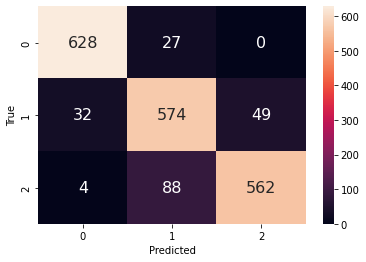

CPU times: user 7min 39s, sys: 3.56 s, total: 7min 42s
Wall time: 7min 41s


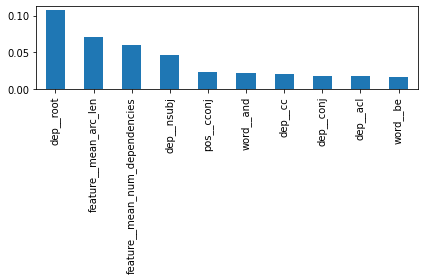

Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV 1/4; 1/12] START extra_trees__max_depth=None, extra_trees__min_samples_leaf=1, vectorizer__word__min_df=3
[CV 1/4; 1/12] END extra_trees__max_depth=None, extra_trees__min_samples_leaf=1, vectorizer__word__min_df=3; Accuracy: (train=1.000, test=0.881) F1: (train=1.000, test=0.881) total time=  24.1s
[CV 2/4; 1/12] START extra_trees__max_depth=None, extra_trees__min_samples_leaf=1, vectorizer__word__min_df=3
[CV 2/4; 1/12] END extra_trees__max_depth=None, extra_trees__min_samples_leaf=1, vectorizer__word__min_df=3; Accuracy: (train=1.000, test=0.879) F1: (train=1.000, test=0.879) total time=  24.2s
[CV 3/4; 1/12] START extra_trees__max_depth=None, extra_trees__min_samples_leaf=1, vectorizer__word__min_df=3
[CV 3/4; 1/12] END extra_trees__max_depth=None, extra_trees__min_samples_leaf=1, vectorizer__word__min_df=3; Accuracy: (train=1.000, test=0.885) F1: (train=1.000, test=0.885) total time=  25.9s
[CV 4/4; 1/12] START extra_

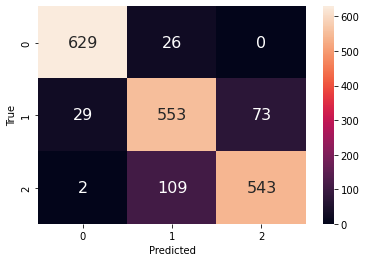

CPU times: user 12min 51s, sys: 4 s, total: 12min 55s
Wall time: 12min 52s


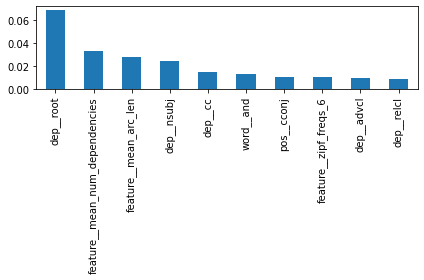

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4; 1/18] START lgbm__colsample_bytree=0.25, lgbm__min_split_gain=0, vectorizer__word__min_df=3
[CV 1/4; 1/18] END lgbm__colsample_bytree=0.25, lgbm__min_split_gain=0, vectorizer__word__min_df=3; Accuracy: (train=1.000, test=0.918) F1: (train=1.000, test=0.918) total time=  14.2s
[CV 2/4; 1/18] START lgbm__colsample_bytree=0.25, lgbm__min_split_gain=0, vectorizer__word__min_df=3
[CV 2/4; 1/18] END lgbm__colsample_bytree=0.25, lgbm__min_split_gain=0, vectorizer__word__min_df=3; Accuracy: (train=1.000, test=0.922) F1: (train=1.000, test=0.922) total time=  13.8s
[CV 3/4; 1/18] START lgbm__colsample_bytree=0.25, lgbm__min_split_gain=0, vectorizer__word__min_df=3
[CV 3/4; 1/18] END lgbm__colsample_bytree=0.25, lgbm__min_split_gain=0, vectorizer__word__min_df=3; Accuracy: (train=1.000, test=0.928) F1: (train=1.000, test=0.928) total time=  14.1s
[CV 4/4; 1/18] START lgbm__colsample_bytree=0.25, lgbm__min_split_gain=0, vectori

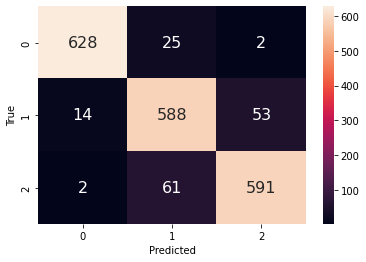

CPU times: user 21min 35s, sys: 9.05 s, total: 21min 44s
Wall time: 21min 38s


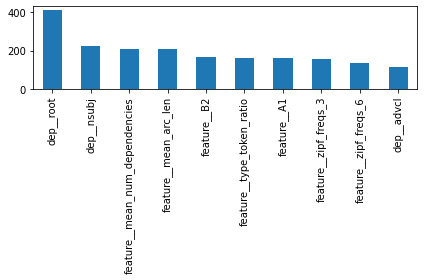

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4; 1/9] START lad__C=0.01, vectorizer__word__min_df=3.....................
[CV 1/4; 1/9] END lad__C=0.01, vectorizer__word__min_df=3; Accuracy: (train=0.933, test=0.896) F1: (train=0.933, test=0.897) total time=   2.7s
[CV 2/4; 1/9] START lad__C=0.01, vectorizer__word__min_df=3.....................
[CV 2/4; 1/9] END lad__C=0.01, vectorizer__word__min_df=3; Accuracy: (train=0.934, test=0.898) F1: (train=0.935, test=0.900) total time=   2.7s
[CV 3/4; 1/9] START lad__C=0.01, vectorizer__word__min_df=3.....................
[CV 3/4; 1/9] END lad__C=0.01, vectorizer__word__min_df=3; Accuracy: (train=0.932, test=0.911) F1: (train=0.933, test=0.912) total time=   2.7s
[CV 4/4; 1/9] START lad__C=0.01, vectorizer__word__min_df=3.....................
[CV 4/4; 1/9] END lad__C=0.01, vectorizer__word__min_df=3; Accuracy: (train=0.932, test=0.912) F1: (train=0.933, test=0.913) total time=   2.7s
[CV 1/4; 2/9] START lad__C=0.01, vectori

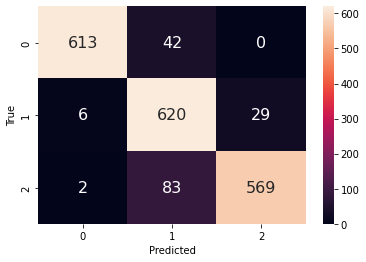

CPU times: user 2min 55s, sys: 11.3 s, total: 3min 6s
Wall time: 2min 56s
Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4; 1/9] START ordinal_ridge__alpha=0.5, vectorizer__word__min_df=3........
[CV 1/4; 1/9] END ordinal_ridge__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.999, test=0.853) F1: (train=0.999, test=0.855) total time=  14.0s
[CV 2/4; 1/9] START ordinal_ridge__alpha=0.5, vectorizer__word__min_df=3........
[CV 2/4; 1/9] END ordinal_ridge__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.999, test=0.847) F1: (train=0.999, test=0.850) total time=  13.4s
[CV 3/4; 1/9] START ordinal_ridge__alpha=0.5, vectorizer__word__min_df=3........
[CV 3/4; 1/9] END ordinal_ridge__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.998, test=0.864) F1: (train=0.998, test=0.866) total time=  13.3s
[CV 4/4; 1/9] START ordinal_ridge__alpha=0.5, vectorizer__word__min_df=3........
[CV 4/4; 1/9] END ordinal_ridge__alpha=0.5, vectorizer__word__min_df=3;

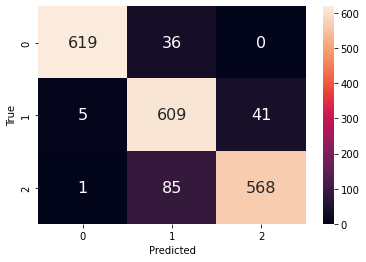

CPU times: user 10min 21s, sys: 36.1 s, total: 10min 57s
Wall time: 7min
Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4; 1/9] START logistic_se__alpha=0.5, vectorizer__word__min_df=3..........
[CV 1/4; 1/9] END logistic_se__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.995, test=0.911) F1: (train=0.995, test=0.911) total time=  37.9s
[CV 2/4; 1/9] START logistic_se__alpha=0.5, vectorizer__word__min_df=3..........
[CV 2/4; 1/9] END logistic_se__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.995, test=0.914) F1: (train=0.995, test=0.914) total time=  34.6s
[CV 3/4; 1/9] START logistic_se__alpha=0.5, vectorizer__word__min_df=3..........
[CV 3/4; 1/9] END logistic_se__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.995, test=0.918) F1: (train=0.995, test=0.919) total time=  41.2s
[CV 4/4; 1/9] START logistic_se__alpha=0.5, vectorizer__word__min_df=3..........
[CV 4/4; 1/9] END logistic_se__alpha=0.5, vectorizer__word__min_df=3; Accuracy

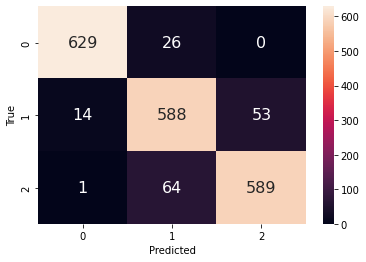

CPU times: user 23min 50s, sys: 1min 11s, total: 25min 2s
Wall time: 14min 2s
Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4; 1/9] START logistic_at__alpha=0.5, vectorizer__word__min_df=3..........
[CV 1/4; 1/9] END logistic_at__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.995, test=0.911) F1: (train=0.995, test=0.911) total time=  31.3s
[CV 2/4; 1/9] START logistic_at__alpha=0.5, vectorizer__word__min_df=3..........
[CV 2/4; 1/9] END logistic_at__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.995, test=0.914) F1: (train=0.995, test=0.914) total time=  25.6s
[CV 3/4; 1/9] START logistic_at__alpha=0.5, vectorizer__word__min_df=3..........
[CV 3/4; 1/9] END logistic_at__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.995, test=0.918) F1: (train=0.995, test=0.919) total time=  29.7s
[CV 4/4; 1/9] START logistic_at__alpha=0.5, vectorizer__word__min_df=3..........
[CV 4/4; 1/9] END logistic_at__alpha=0.5, vectorizer__word__min_df=3; Acc

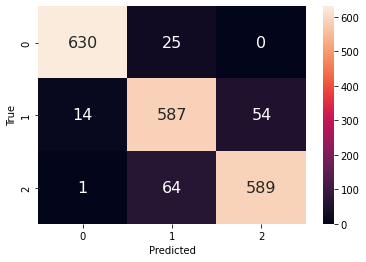

CPU times: user 22min 7s, sys: 1min 7s, total: 23min 15s
Wall time: 13min 6s
Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4; 1/9] START logistic_it__alpha=0.5, vectorizer__word__min_df=3..........
[CV 1/4; 1/9] END logistic_it__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.995, test=0.911) F1: (train=0.995, test=0.911) total time=  30.8s
[CV 2/4; 1/9] START logistic_it__alpha=0.5, vectorizer__word__min_df=3..........
[CV 2/4; 1/9] END logistic_it__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.995, test=0.914) F1: (train=0.995, test=0.914) total time=  27.0s
[CV 3/4; 1/9] START logistic_it__alpha=0.5, vectorizer__word__min_df=3..........
[CV 3/4; 1/9] END logistic_it__alpha=0.5, vectorizer__word__min_df=3; Accuracy: (train=0.995, test=0.918) F1: (train=0.995, test=0.919) total time=  26.9s
[CV 4/4; 1/9] START logistic_it__alpha=0.5, vectorizer__word__min_df=3..........
[CV 4/4; 1/9] END logistic_it__alpha=0.5, vectorizer__word__min_df=3; Accu

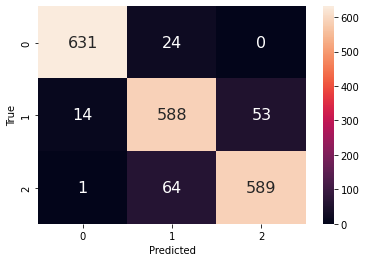

CPU times: user 19min 55s, sys: 1min 1s, total: 20min 56s
Wall time: 11min 54s


In [ ]:
for feature_set in feature_sets:
    news.classification(feature_set, clfs, column_trans_dct, scaler)
    news.save_results(feature_set)


lexical
Baseline: 0.3335


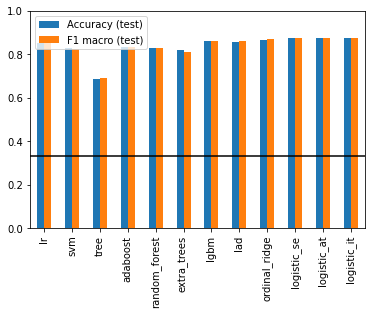

Best result:
logistic_it
Accuracy (test): 0.8758
F1 macro (test): 0.876

grammatical
Baseline: 0.3335


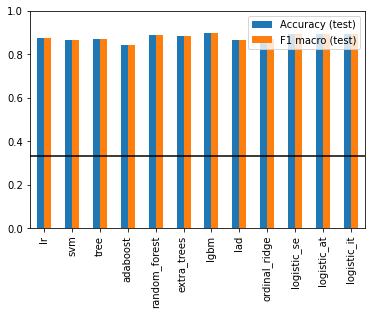

Best result:
lgbm
Accuracy (test): 0.8977
F1 macro (test): 0.8979

all
Baseline: 0.3335


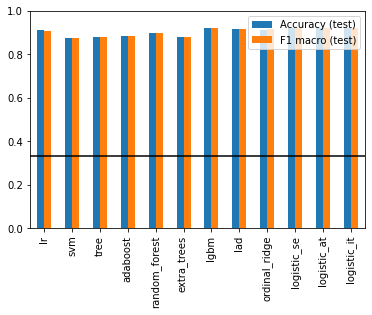

Best result:
logistic_it
Accuracy (test): 0.9206
F1 macro (test): 0.9208


In [ ]:
for feature_set in feature_sets:
    news.plot_results(feature_set)

## Classification for Days

In [40]:
days = Dataset4Classification(df_days, "days", train=False)

lexical-lr
Accuracy: 0.8113
F1 macro: 0.8082


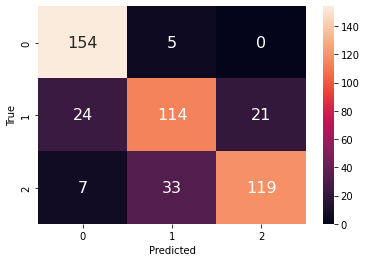

lexical-svm
Accuracy: 0.8344
F1 macro: 0.8293


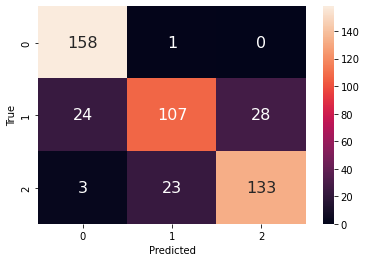

lexical-tree
Accuracy: 0.6268
F1 macro: 0.6298


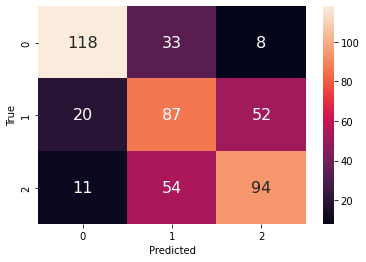

lexical-adaboost
Accuracy: 0.7610
F1 macro: 0.7679


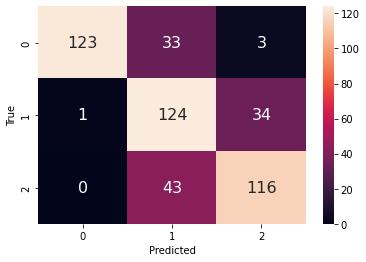

lexical-random_forest
Accuracy: 0.7757
F1 macro: 0.7703


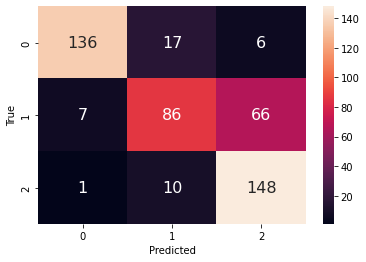

lexical-extra_trees
Accuracy: 0.7463
F1 macro: 0.7233


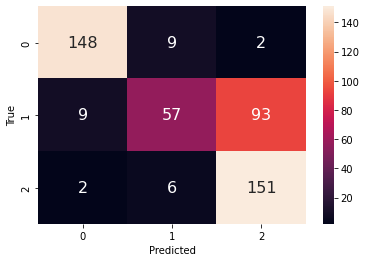

lexical-lgbm
Accuracy: 0.8071
F1 macro: 0.8021


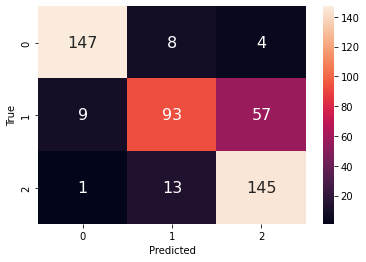

lexical-lad
Accuracy: 0.7065
F1 macro: 0.6984


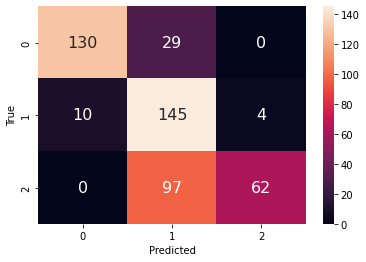

lexical-ordinal_ridge
Accuracy: 0.7317
F1 macro: 0.7281


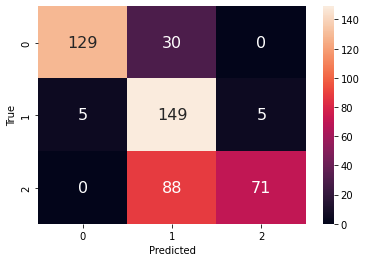

lexical-logistic_se
Accuracy: 0.7820
F1 macro: 0.7793


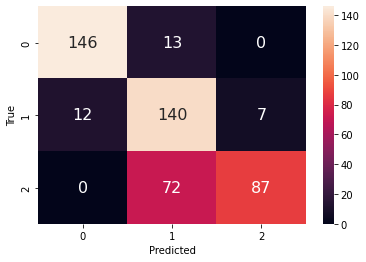

lexical-logistic_at
Accuracy: 0.7841
F1 macro: 0.7817


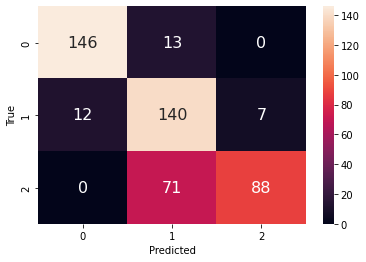

lexical-logistic_it
Accuracy: 0.7820
F1 macro: 0.7796


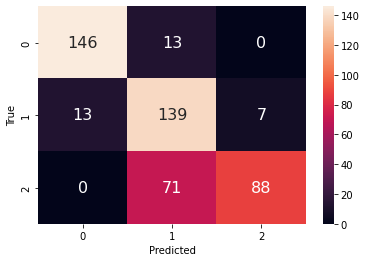

grammatical-lr
Accuracy: 0.7610
F1 macro: 0.7439


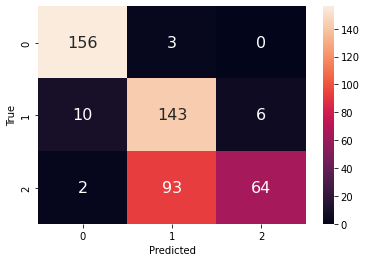

grammatical-svm
Accuracy: 0.7589
F1 macro: 0.7430


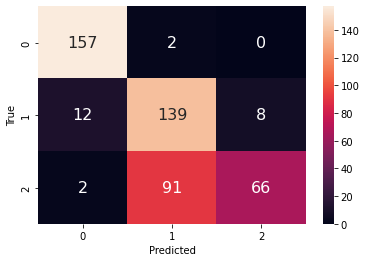

grammatical-tree
Accuracy: 0.7065
F1 macro: 0.6853


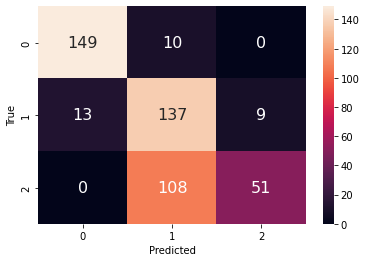

grammatical-adaboost
Accuracy: 0.7568
F1 macro: 0.7545


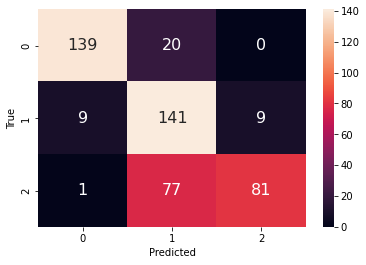

grammatical-random_forest
Accuracy: 0.7442
F1 macro: 0.7286


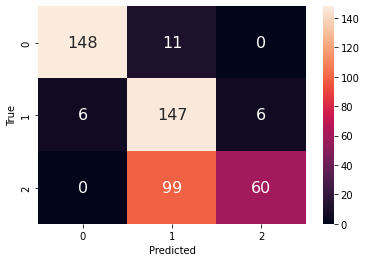

grammatical-extra_trees
Accuracy: 0.7736
F1 macro: 0.7677


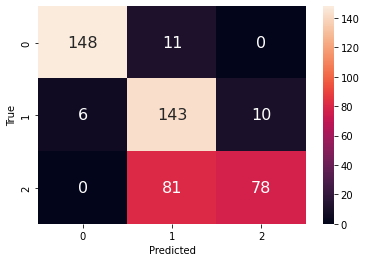

grammatical-lgbm
Accuracy: 0.7736
F1 macro: 0.7679


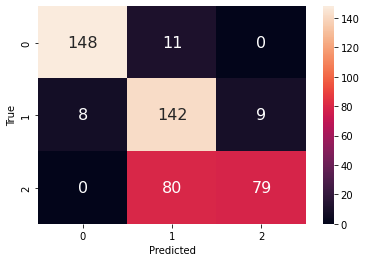

grammatical-lad
Accuracy: 0.6876
F1 macro: 0.6636


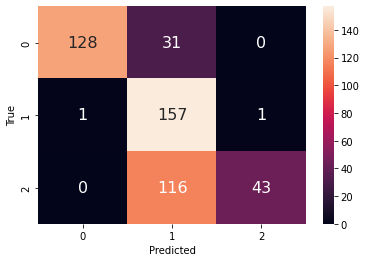

grammatical-ordinal_ridge
Accuracy: 0.6792
F1 macro: 0.6566


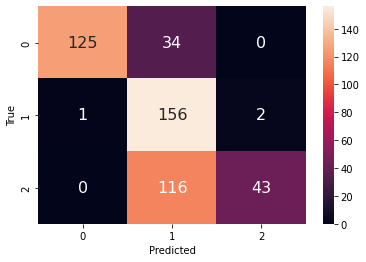

grammatical-logistic_se
Accuracy: 0.7317
F1 macro: 0.7057


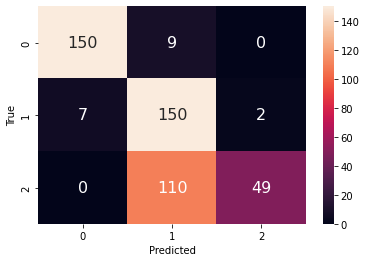

grammatical-logistic_at
Accuracy: 0.7358
F1 macro: 0.7103


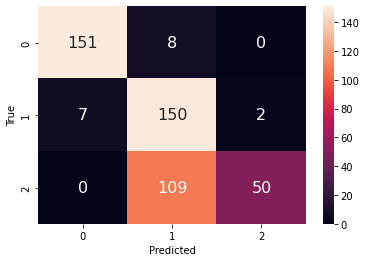

grammatical-logistic_it
Accuracy: 0.7379
F1 macro: 0.7132


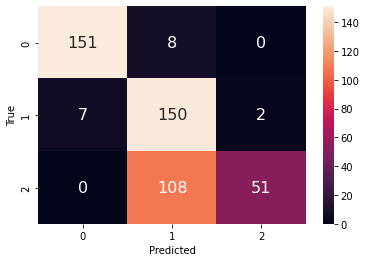

all-lr
Accuracy: 0.7883
F1 macro: 0.7790


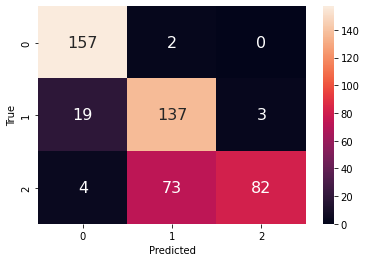

all-svm
Accuracy: 0.8323
F1 macro: 0.8306


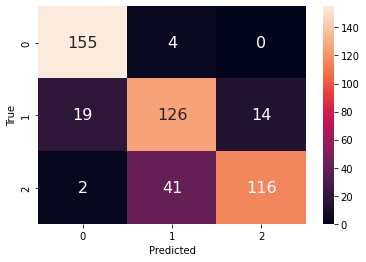

all-tree
Accuracy: 0.6646
F1 macro: 0.6230


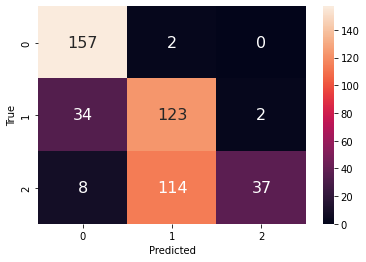

all-adaboost
Accuracy: 0.7484
F1 macro: 0.7403


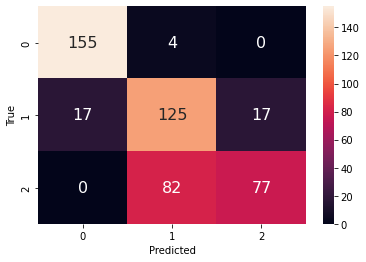

all-random_forest
Accuracy: 0.8302
F1 macro: 0.8300


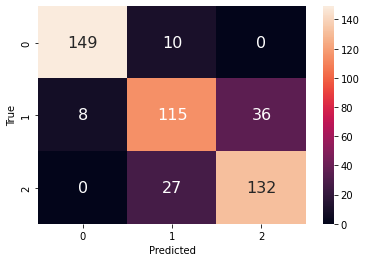

all-extra_trees
Accuracy: 0.8428
F1 macro: 0.8429


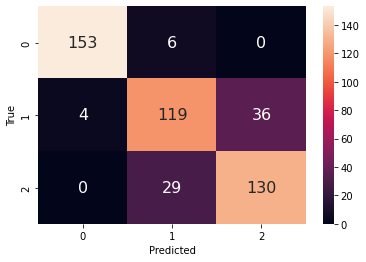

all-lgbm
Accuracy: 0.8176
F1 macro: 0.8101


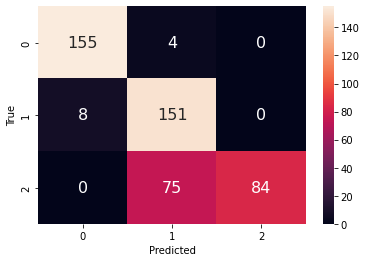

all-lad
Accuracy: 0.7275
F1 macro: 0.7025


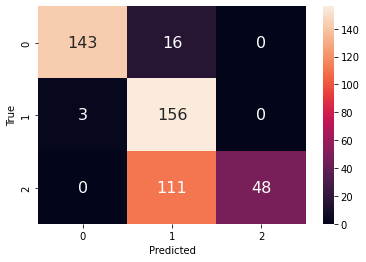

all-ordinal_ridge
Accuracy: 0.7296
F1 macro: 0.6961


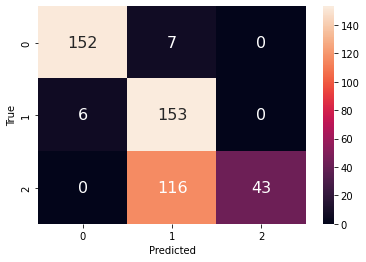

all-logistic_se
Accuracy: 0.7673
F1 macro: 0.7477


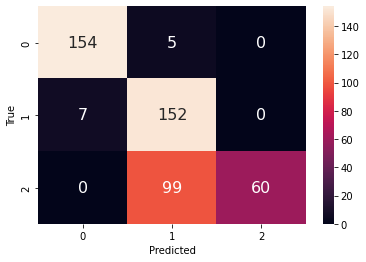

all-logistic_at
Accuracy: 0.7652
F1 macro: 0.7456


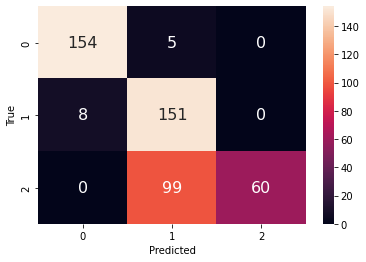

all-logistic_it
Accuracy: 0.7673
F1 macro: 0.7473


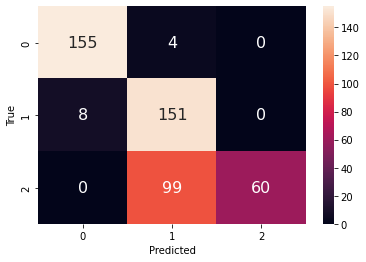

In [ ]:
for feature_set in feature_sets:
    days.prediction(feature_set, clfs)
    days.save_results(feature_set)


lexical
Baseline: 0.3333


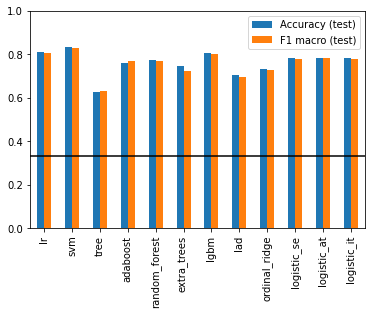

Best result:
svm
Accuracy (test): 0.8344
F1 macro (test): 0.8293

grammatical
Baseline: 0.3333


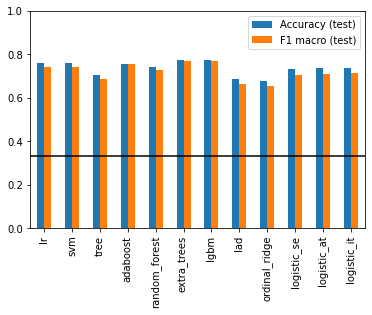

Best result:
lgbm
Accuracy (test): 0.7736
F1 macro (test): 0.7679

all
Baseline: 0.3333


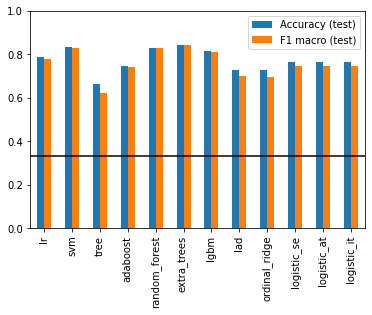

Best result:
extra_trees
Accuracy (test): 0.8428
F1 macro (test): 0.8429


In [ ]:
for feature_set in feature_sets:
    days.plot_results(feature_set)